In [1]:
#
# NOTE: This machine learning program is for predicting TC formation, using
#       input dataset in the NETCDF format. The program treats different 
#       2D input fields as different channels of an image. This specific 
#       program requires a set of 12 2D-variables (12-channel image) and 
#       consists of three stages
#       - Stage 1: reading NETCDF input and generating (X,y) data with a 
#                  given image sizes, which are then saved by pickle;
#       - Stage 2: import the saved pickle (X,y) pair and build a CNN model
#                  with a given training/validation ratio, and then save
#                  the train model under tcg_CNN.model.
#       - Stage 3: import the trained model from Stage 2, and make a list
#                  of prediction from normalized test data. 
#
# INPUT: This Stage 1 script requires two specific input datasets, including
#       1. 7 meterological vars u, v,abs vort, tmp, RH, vvels, sst, cape  
#          corresponding to negative cases (i.e. no TC formation within the 
#          domain). 
#       2. Similar data but for positive cases (i.e., there is a TC centered
#          on the domain)  
#        Remarks: Note that these data must be on the standard 19 vertical
#        levels 1000, 975, 950, 925, 900, 850, 800, 750, 700, 650, 600, 
#        550, 500, 450, 400, 350, 300, 250, 200. Also, all field vars must
#        be resize to cover an area of 30x30 around the TC center for the 
#        positive data cases.
#
# OUTPUT: A set of pairs (X,y) needed for CNN training
#
# HIST: - 25, Oct 22: Created by CK
#       - 27, Oct 22: Added a classification loop to simplify the code
#       - 01, Nov 22: Modified to include more channels  
#       - 02, Feb 23: Revised for jupiter-notebook workflow
#
# AUTH: Chanh Kieu (Indiana University, Bloomington. Email: ckieu@iu.edu) 
#
#==========================================================================
import netCDF4
#import xarray as xr
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
#
# define data source and reading pos/neg data 
#
IMG_SIZE = 30
rootdir="/N/project/pfec_climo/qmnguyen/tc_prediction/binary_datasets/ncep_WP_binary_0h/"
#rootdir="/N/u/ckieu/Carbonate/python/testdata/"
tcg_class = ['pos','neg']
array_raw = []
for tcg in tcg_class:
    if tcg == "pos":
        datadir=rootdir + 'pos'
    else:
        datadir=rootdir + 'neg'
    print('Input data dir is: ',datadir)
    for img in tqdm(os.listdir(datadir)):
        try:
            print('Processing file:', img)           
            file=datadir+'/'+img
            f = netCDF4.Dataset(file)
            abv = f.variables['absvprs']
            nx = np.size(abv[0,0,:])
            ny = np.size(abv[0,:,0])
            nz = np.size(abv[:,0,0])
            print('nx = ',nx,' ny = ',ny )             
            a2 = np.zeros((nx,ny,12))         
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,0] = abv[1,j,i]    # abs vort at 950 mb
            rel = f.variables['rhprs'] 
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,1] = rel[7,j,i]    # RH at 750 mb 
            sfc = f.variables['pressfc']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,2] = sfc[j,i]      # surface pressure
            tmp = f.variables['tmpprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,3] = tmp[15,j,i]   # temperature at 400 mb
            tsf = f.variables['tmpsfc']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,4] = tsf[j,i]      # surface temperature
            ugr = f.variables['ugrdprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,5] = ugr[3,j,i]    # u-wind at 900 mb
                    a2[i,j,6] = ugr[17,j,i]   # u-wind at 300 mb
            vgr = f.variables['vgrdprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,7] = vgr[3,j,i]    # v-wind at 900 mb
                    a2[i,j,8] = vgr[17,j,i]   # v-wind at 300 mb
            hgt = f.variables['hgtprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,9] = hgt[3,j,i]    # geopotential at 850 mb
            wgr = f.variables['vvelprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,10] = wgr[3,j,i]   # w-wind at 900 mb
                    a2[i,j,11] = wgr[17,j,i]  # w-wind at 300 mb
            a3 = cv2.resize(a2, (IMG_SIZE, IMG_SIZE)) 
            print('a3 shape is :',a3.shape)
            #input('Enter to continue...')
            if tcg == "pos":
                array_raw.append([a3, 1])
            else:
                array_raw.append([a3, 0])
        except Exception as e:
            pass

Input data dir is:  /N/project/pfec_climo/qmnguyen/tc_prediction/binary_datasets/ncep_WP_binary_0h/pos


  0%|                                                                                                                                                                 | 0/352 [00:00<?, ?it/s]

Processing file: 20140905_06_00_18.6_128.5_2014248N19129.nc
nx =  30  ny =  30


  0%|▍                                                                                                                                                        | 1/352 [00:01<10:36,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100913_06_00_16.6_137.4_2010256N17137.nc
nx =  30  ny =  30


  1%|▊                                                                                                                                                        | 2/352 [00:03<10:33,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120713_18_00_18.7_143.8_2012196N19144.nc
nx =  30  ny =  30


  1%|█▎                                                                                                                                                       | 3/352 [00:05<10:31,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101004_12_00_17.5_110.1_2010278N18110.nc
nx =  30  ny =  30


  1%|█▋                                                                                                                                                       | 4/352 [00:07<10:29,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201109_06_00_12.0_130.9_2020314N12131.nc
nx =  30  ny =  31


  1%|██▏                                                                                                                                                      | 5/352 [00:09<10:35,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080526_00_00_9.9_140.8_2008147N10141.nc
nx =  30  ny =  30


  2%|██▌                                                                                                                                                      | 6/352 [00:10<10:30,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131027_18_00_12.7_142.2_2013301N13142.nc
nx =  30  ny =  30


  2%|███                                                                                                                                                      | 7/352 [00:12<10:29,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100906_06_00_23.9_124.8_2010249N24125.nc
nx =  30  ny =  30


  2%|███▍                                                                                                                                                     | 8/352 [00:14<10:26,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151013_00_00_12.6_161.4_2015286N13161.nc
nx =  30  ny =  30


  3%|███▉                                                                                                                                                     | 9/352 [00:16<10:23,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131111_12_00_6.0_129.8_2013316N06130.nc
nx =  30  ny =  31


  3%|████▎                                                                                                                                                   | 10/352 [00:18<10:27,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160922_00_00_11.0_144.0_2016266N11144.nc
nx =  31  ny =  31


  3%|████▊                                                                                                                                                   | 11/352 [00:20<10:35,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130816_12_00_25.8_131.5_2013229N26132.nc
nx =  30  ny =  30


  3%|█████▏                                                                                                                                                  | 12/352 [00:21<10:29,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120718_12_00_14.9_128.6_2012201N15129.nc
nx =  30  ny =  30


  4%|█████▌                                                                                                                                                  | 13/352 [00:23<10:24,  1.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160722_18_00_24.7_151.5_2016205N25152.nc
nx =  30  ny =  30


  4%|██████                                                                                                                                                  | 14/352 [00:25<10:21,  1.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150913_18_00_13.9_151.6_2015257N14152.nc
nx =  30  ny =  30


  4%|██████▍                                                                                                                                                 | 15/352 [00:27<10:17,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080506_18_00_7.2_134.2_2008128N07134.nc
nx =  30  ny =  30


  5%|██████▉                                                                                                                                                 | 16/352 [00:29<10:13,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080927_18_00_8.2_139.4_2008272N08139.nc
nx =  30  ny =  30


  5%|███████▎                                                                                                                                                | 17/352 [00:31<10:10,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210719_00_00_20.9_113.1_2021200N21113.nc
nx =  30  ny =  30


  5%|███████▊                                                                                                                                                | 18/352 [00:32<10:06,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151012_00_00_13.9_150.8_2015285N14151.nc
nx =  30  ny =  30


  5%|████████▏                                                                                                                                               | 19/352 [00:34<10:02,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091120_06_00_6.2_128.9_2009324N06129.nc
nx =  30  ny =  30


  6%|████████▋                                                                                                                                               | 20/352 [00:36<09:59,  1.80s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131009_00_00_14.0_149.0_2013282N14149.nc
nx =  31  ny =  31


  6%|█████████                                                                                                                                               | 21/352 [00:38<10:10,  1.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180721_06_00_20.6_158.8_2018202N21159.nc
nx =  30  ny =  30


  6%|█████████▌                                                                                                                                              | 22/352 [00:40<10:04,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210906_06_00_14.0_138.3_2021249N14138.nc
nx =  30  ny =  31


  7%|█████████▉                                                                                                                                              | 23/352 [00:42<10:04,  1.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110808_12_00_17.0_139.4_2011221N17139.nc
nx =  30  ny =  31


  7%|██████████▎                                                                                                                                             | 24/352 [00:43<10:05,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171008_12_00_16.5_113.4_2017282N17113.nc
nx =  30  ny =  30


  7%|██████████▊                                                                                                                                             | 25/352 [00:45<09:59,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210512_18_00_7.1_129.8_2021133N07130.nc
nx =  30  ny =  30


  7%|███████████▏                                                                                                                                            | 26/352 [00:47<09:54,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200809_12_00_16.8_118.3_2020223N17118.nc
nx =  30  ny =  30


  8%|███████████▋                                                                                                                                            | 27/352 [00:49<09:55,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190830_00_00_18.2_126.3_2019242N18126.nc
nx =  30  ny =  30


  8%|████████████                                                                                                                                            | 28/352 [00:51<09:52,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080923_12_00_11.7_139.6_2008268N12140.nc
nx =  30  ny =  30


  8%|████████████▌                                                                                                                                           | 29/352 [00:53<09:50,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081017_18_00_20.3_152.2_2008292N20152.nc
nx =  30  ny =  30


  9%|████████████▉                                                                                                                                           | 30/352 [00:54<09:47,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130831_00_00_25.6_121.5_2013243N26122.nc
nx =  30  ny =  30


  9%|█████████████▍                                                                                                                                          | 31/352 [00:56<09:44,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081012_00_00_16.8_109.3_2008286N17109.nc
nx =  30  ny =  30


  9%|█████████████▊                                                                                                                                          | 32/352 [00:58<09:41,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160830_18_00_20.8_123.0_2016244N21123.nc
nx =  31  ny =  30


  9%|██████████████▎                                                                                                                                         | 33/352 [01:00<09:42,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090622_00_00_10.0_132.3_2009173N10132.nc
nx =  30  ny =  31


 10%|██████████████▋                                                                                                                                         | 34/352 [01:02<09:47,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150506_12_00_4.1_157.9_2015127N04158.nc
nx =  30  ny =  30


 10%|███████████████                                                                                                                                         | 35/352 [01:04<09:41,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160818_12_00_22.3_152.8_2016232N22153.nc
nx =  30  ny =  30


 10%|███████████████▌                                                                                                                                        | 36/352 [01:05<09:35,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160702_12_00_8.2_145.2_2016185N08145.nc
nx =  30  ny =  30


 11%|███████████████▉                                                                                                                                        | 37/352 [01:07<09:30,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171011_00_00_15.5_134.0_2017284N15134.nc
nx =  31  ny =  30


 11%|████████████████▍                                                                                                                                       | 38/352 [01:09<09:32,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150801_06_00_28.7_145.7_2015213N29146.nc
nx =  30  ny =  30


 11%|████████████████▊                                                                                                                                       | 39/352 [01:11<09:26,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201024_00_00_12.5_131.2_2020298N13131.nc
nx =  30  ny =  30


 11%|█████████████████▎                                                                                                                                      | 40/352 [01:13<09:23,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191028_12_00_10.6_118.2_2019302N11118.nc
nx =  30  ny =  30


 12%|█████████████████▋                                                                                                                                      | 41/352 [01:14<09:20,  1.80s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181116_18_00_9.9_113.1_2018321N10113.nc
nx =  30  ny =  30


 12%|██████████████████▏                                                                                                                                     | 42/352 [01:16<09:17,  1.80s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180814_00_00_23.2_128.2_2018226N23128.nc
nx =  30  ny =  30


 12%|██████████████████▌                                                                                                                                     | 43/352 [01:18<09:19,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120923_06_00_15.6_140.5_2012267N16141.nc
nx =  30  ny =  30


 12%|███████████████████                                                                                                                                     | 44/352 [01:20<09:17,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110713_12_00_15.3_133.6_2011195N15134.nc
nx =  30  ny =  30


 13%|███████████████████▍                                                                                                                                    | 45/352 [01:22<09:16,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201108_12_00_12.9_117.9_2020314N13118.nc
nx =  30  ny =  30


 13%|███████████████████▊                                                                                                                                    | 46/352 [01:23<09:15,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180806_00_00_18.2_134.1_2018218N18134.nc
nx =  30  ny =  30


 13%|████████████████████▎                                                                                                                                   | 47/352 [01:25<09:11,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200915_18_00_12.8_118.4_2020260N13118.nc
nx =  30  ny =  30


 14%|████████████████████▋                                                                                                                                   | 48/352 [01:27<09:10,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110923_18_00_16.2_110.6_2011267N16111.nc
nx =  30  ny =  30


 14%|█████████████████████▏                                                                                                                                  | 49/352 [01:29<09:08,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151001_06_00_16.9_166.9_2015274N17167.nc
nx =  30  ny =  30


 14%|█████████████████████▌                                                                                                                                  | 50/352 [01:31<09:06,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160924_18_00_14.9_164.6_2016269N15165.nc
nx =  30  ny =  30


 14%|██████████████████████                                                                                                                                  | 51/352 [01:32<09:04,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130728_18_00_12.7_121.7_2013210N13122.nc
nx =  30  ny =  30


 15%|██████████████████████▍                                                                                                                                 | 52/352 [01:34<09:00,  1.80s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160815_06_00_21.8_117.0_2016228N22117.nc
nx =  30  ny =  30


 15%|██████████████████████▉                                                                                                                                 | 53/352 [01:36<08:58,  1.80s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110923_00_00_12.8_139.4_2011266N13139.nc
nx =  30  ny =  30


 15%|███████████████████████▎                                                                                                                                | 54/352 [01:38<08:57,  1.80s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170720_00_00_22.9_177.9_2017201N23178.nc
nx =  30  ny =  30


 16%|███████████████████████▊                                                                                                                                | 55/352 [01:40<08:54,  1.80s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170714_00_00_16.0_114.1_2017195N16114.nc
nx =  30  ny =  31


 16%|████████████████████████▏                                                                                                                               | 56/352 [01:41<08:57,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100717_00_00_15.3_123.3_2010198N15123.nc
nx =  30  ny =  30


 16%|████████████████████████▌                                                                                                                               | 57/352 [01:43<08:55,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080912_18_00_28.1_147.5_2008257N28148.nc
nx =  30  ny =  30


 16%|█████████████████████████                                                                                                                               | 58/352 [01:45<08:52,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180816_12_00_11.3_160.3_2018229N11160.nc
nx =  30  ny =  30


 17%|█████████████████████████▍                                                                                                                              | 59/352 [01:47<08:52,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080907_12_00_15.8_127.6_2008252N16128.nc
nx =  30  ny =  30


 17%|█████████████████████████▉                                                                                                                              | 60/352 [01:49<08:49,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110620_18_00_11.2_133.4_2011172N11133.nc
nx =  30  ny =  30


 17%|██████████████████████████▎                                                                                                                             | 61/352 [01:51<08:47,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130816_00_00_23.1_123.6_2013228N23124.nc
nx =  30  ny =  30


 18%|██████████████████████████▊                                                                                                                             | 62/352 [01:52<08:45,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140716_06_00_10.0_136.8_2014197N10137.nc
nx =  30  ny =  31


 18%|███████████████████████████▏                                                                                                                            | 63/352 [01:54<08:48,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090806_18_00_19.2_140.3_2009219N19140.nc
nx =  30  ny =  30


 18%|███████████████████████████▋                                                                                                                            | 64/352 [01:56<08:44,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161123_06_00_9.3_129.9_2016328N09130.nc
nx =  30  ny =  30


 18%|████████████████████████████                                                                                                                            | 65/352 [01:58<08:40,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171103_00_00_7.2_102.4_2017307N07102.nc
nx =  30  ny =  30


 19%|████████████████████████████▌                                                                                                                           | 66/352 [02:00<08:38,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120910_00_00_8.6_134.8_2012254N09135.nc
nx =  30  ny =  30


 19%|████████████████████████████▉                                                                                                                           | 67/352 [02:01<08:36,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160716_18_00_18.3_130.9_2016199N18131.nc
nx =  30  ny =  30


 19%|█████████████████████████████▎                                                                                                                          | 68/352 [02:03<08:33,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131017_00_00_13.8_152.6_2013290N14153.nc
nx =  30  ny =  30


 20%|█████████████████████████████▊                                                                                                                          | 69/352 [02:05<08:31,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080927_18_00_14.6_112.9_2008272N15113.nc
nx =  30  ny =  30


 20%|██████████████████████████████▏                                                                                                                         | 70/352 [02:07<08:30,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121021_12_00_6.4_135.0_2012296N06135.nc
nx =  31  ny =  30


 20%|██████████████████████████████▋                                                                                                                         | 71/352 [02:09<08:34,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091121_06_00_5.6_147.9_2009325N06148.nc
nx =  30  ny =  30


 20%|███████████████████████████████                                                                                                                         | 72/352 [02:11<08:30,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100820_18_00_17.1_118.6_2010233N17119.nc
nx =  30  ny =  30


 21%|███████████████████████████████▌                                                                                                                        | 73/352 [02:12<08:26,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100831_06_00_11.8_145.7_2010243N12146.nc
nx =  30  ny =  30


 21%|███████████████████████████████▉                                                                                                                        | 74/352 [02:14<08:22,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080811_00_00_23.7_122.2_2008224N24122.nc
nx =  30  ny =  30


 21%|████████████████████████████████▍                                                                                                                       | 75/352 [02:16<08:23,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110913_12_00_19.4_153.7_2011257N19154.nc
nx =  30  ny =  30


 22%|████████████████████████████████▊                                                                                                                       | 76/352 [02:18<08:21,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160526_00_00_17.6_114.6_2016147N18115.nc
nx =  30  ny =  30


 22%|█████████████████████████████████▎                                                                                                                      | 77/352 [02:20<08:18,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170826_18_00_17.8_147.0_2017239N18147.nc
nx =  31  ny =  30


 22%|█████████████████████████████████▋                                                                                                                      | 78/352 [02:21<08:21,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100827_18_00_14.6_142.2_2010240N15142.nc
nx =  30  ny =  30


 22%|██████████████████████████████████                                                                                                                      | 79/352 [02:23<08:18,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200831_12_00_22.9_145.8_2020245N23146.nc
nx =  30  ny =  30


 23%|██████████████████████████████████▌                                                                                                                     | 80/352 [02:25<08:16,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140917_00_00_12.6_135.0_2014260N13135.nc
nx =  31  ny =  30


 23%|██████████████████████████████████▉                                                                                                                     | 81/352 [02:27<08:18,  1.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201019_00_00_13.8_129.4_2020293N14129.nc
nx =  30  ny =  30


 23%|███████████████████████████████████▍                                                                                                                    | 82/352 [02:29<08:14,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090928_12_00_7.3_163.8_2009272N07164.nc
nx =  30  ny =  30


 24%|███████████████████████████████████▊                                                                                                                    | 83/352 [02:31<08:11,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131102_06_00_6.6_161.6_2013306N07162.nc
nx =  30  ny =  30


 24%|████████████████████████████████████▎                                                                                                                   | 84/352 [02:32<08:08,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180603_18_00_9.7_131.8_2018155N10132.nc
nx =  30  ny =  30


 24%|████████████████████████████████████▋                                                                                                                   | 85/352 [02:34<08:05,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180509_00_00_14.5_153.0_2018129N15153.nc
nx =  31  ny =  30


 24%|█████████████████████████████████████▏                                                                                                                  | 86/352 [02:36<08:07,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080514_06_00_11.5_115.6_2008135N12116.nc
nx =  30  ny =  30


 25%|█████████████████████████████████████▌                                                                                                                  | 87/352 [02:38<08:03,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170819_12_00_19.1_130.1_2017232N19130.nc
nx =  30  ny =  30


 25%|██████████████████████████████████████                                                                                                                  | 88/352 [02:40<07:59,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170725_00_00_12.7_128.9_2017206N13129.nc
nx =  30  ny =  30


 25%|██████████████████████████████████████▍                                                                                                                 | 89/352 [02:41<07:55,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200801_06_00_20.9_127.9_2020214N21128.nc
nx =  30  ny =  30


 26%|██████████████████████████████████████▊                                                                                                                 | 90/352 [02:43<07:54,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080812_18_00_22.4_134.3_2008226N22134.nc
nx =  30  ny =  30


 26%|███████████████████████████████████████▎                                                                                                                | 91/352 [02:45<07:52,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100919_12_00_15.4_149.1_2010263N15149.nc
nx =  30  ny =  30


 26%|███████████████████████████████████████▋                                                                                                                | 92/352 [02:47<07:50,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150729_18_00_13.3_162.2_2015211N13162.nc
nx =  30  ny =  30


 26%|████████████████████████████████████████▏                                                                                                               | 93/352 [02:49<07:46,  1.80s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110726_12_00_9.0_144.5_2011208N09145.nc
nx =  30  ny =  31


 27%|████████████████████████████████████████▌                                                                                                               | 94/352 [02:51<07:50,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101110_12_00_14.4_111.7_2010315N14112.nc
nx =  30  ny =  30


 27%|█████████████████████████████████████████                                                                                                               | 95/352 [02:52<07:47,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091013_18_00_9.6_153.5_2009287N10154.nc
nx =  30  ny =  30


 27%|█████████████████████████████████████████▍                                                                                                              | 96/352 [02:54<07:45,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150619_18_00_14.9_112.2_2015171N15112.nc
nx =  30  ny =  30


 28%|█████████████████████████████████████████▉                                                                                                              | 97/352 [02:56<07:43,  1.82s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140702_12_00_8.5_147.3_2014184N08147.nc
nx =  30  ny =  30


 28%|██████████████████████████████████████████▎                                                                                                             | 98/352 [02:58<07:40,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161012_18_00_12.5_129.7_2016287N13130.nc
nx =  30  ny =  30


 28%|██████████████████████████████████████████▊                                                                                                             | 99/352 [03:00<07:37,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170610_00_00_13.2_119.4_2017161N13119.nc
nx =  30  ny =  30


 28%|██████████████████████████████████████████▉                                                                                                            | 100/352 [03:01<07:35,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150919_18_00_13.5_148.1_2015263N14148.nc
nx =  30  ny =  30


 29%|███████████████████████████████████████████▎                                                                                                           | 101/352 [03:03<07:35,  1.81s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151116_18_00_4.0_163.8_2015321N04164.nc
nx =  30  ny =  30


 29%|███████████████████████████████████████████▊                                                                                                           | 102/352 [03:05<07:37,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110905_18_00_18.1_132.9_2011249N18133.nc
nx =  30  ny =  30


 29%|████████████████████████████████████████████▏                                                                                                          | 103/352 [03:07<07:34,  1.83s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081114_18_00_8.2_121.9_2008320N08122.nc
nx =  30  ny =  30


 30%|████████████████████████████████████████████▌                                                                                                          | 104/352 [03:09<07:38,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101020_06_00_16.3_146.5_2010293N16147.nc
nx =  30  ny =  30


 30%|█████████████████████████████████████████████                                                                                                          | 105/352 [03:11<07:36,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210705_00_00_18.2_125.3_2021186N18125.nc
nx =  30  ny =  30


 30%|█████████████████████████████████████████████▍                                                                                                         | 106/352 [03:13<07:34,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190802_06_00_14.5_134.3_2019214N15134.nc
nx =  30  ny =  30


 30%|█████████████████████████████████████████████▉                                                                                                         | 107/352 [03:14<07:42,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190924_12_00_9.6_155.0_2019268N10155.nc
nx =  31  ny =  30


 31%|██████████████████████████████████████████████▎                                                                                                        | 108/352 [03:16<07:43,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210803_00_00_21.3_113.4_2021215N21113.nc
nx =  30  ny =  30


 31%|██████████████████████████████████████████████▊                                                                                                        | 109/352 [03:18<07:41,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090927_00_00_9.9_147.5_2009270N10148.nc
nx =  30  ny =  30


 31%|███████████████████████████████████████████████▏                                                                                                       | 110/352 [03:20<07:38,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080513_18_00_16.2_125.1_2008135N16125.nc
nx =  30  ny =  30


 32%|███████████████████████████████████████████████▌                                                                                                       | 111/352 [03:22<07:34,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170721_06_00_18.6_124.0_2017202N19124.nc
nx =  30  ny =  30


 32%|████████████████████████████████████████████████                                                                                                       | 112/352 [03:24<07:31,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130917_00_00_15.4_112.2_2013260N15112.nc
nx =  30  ny =  30


 32%|████████████████████████████████████████████████▍                                                                                                      | 113/352 [03:26<07:32,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180810_00_00_16.1_146.6_2018222N16147.nc
nx =  30  ny =  30


 32%|████████████████████████████████████████████████▉                                                                                                      | 114/352 [03:28<07:28,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210728_00_00_32.6_117.8_2021209N33118.nc
nx =  30  ny =  30


 33%|█████████████████████████████████████████████████▎                                                                                                     | 115/352 [03:30<07:21,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080809_12_00_27.3_151.4_2008223N27151.nc
nx =  30  ny =  30


 33%|█████████████████████████████████████████████████▊                                                                                                     | 116/352 [03:31<07:19,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110608_00_00_13.4_121.5_2011159N13122.nc
nx =  30  ny =  30


 33%|██████████████████████████████████████████████████▏                                                                                                    | 117/352 [03:33<07:15,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161030_18_00_10.1_146.9_2016305N10147.nc
nx =  30  ny =  30


 34%|██████████████████████████████████████████████████▌                                                                                                    | 118/352 [03:35<07:17,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190804_00_00_15.5_146.6_2019216N16147.nc
nx =  30  ny =  30


 34%|███████████████████████████████████████████████████                                                                                                    | 119/352 [03:37<07:14,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130929_06_00_26.3_151.6_2013272N26152.nc
nx =  30  ny =  30


 34%|███████████████████████████████████████████████████▍                                                                                                   | 120/352 [03:39<07:10,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180730_00_00_26.5_152.3_2018211N27152.nc
nx =  30  ny =  30


 34%|███████████████████████████████████████████████████▉                                                                                                   | 121/352 [03:41<07:06,  1.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110821_06_00_11.9_128.8_2011233N12129.nc
nx =  30  ny =  30


 35%|████████████████████████████████████████████████████▎                                                                                                  | 122/352 [03:43<07:30,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180713_12_00_19.0_137.8_2018195N19138.nc
nx =  30  ny =  31


 35%|████████████████████████████████████████████████████▊                                                                                                  | 123/352 [03:45<07:25,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171031_12_00_7.5_107.8_2017305N08108.nc
nx =  30  ny =  30


 35%|█████████████████████████████████████████████████████▏                                                                                                 | 124/352 [03:47<07:16,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170910_00_00_14.3_130.0_2017253N14130.nc
nx =  31  ny =  30


 36%|█████████████████████████████████████████████████████▌                                                                                                 | 125/352 [03:49<07:15,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150701_18_00_13.3_129.8_2015183N13130.nc
nx =  30  ny =  30


 36%|██████████████████████████████████████████████████████                                                                                                 | 126/352 [03:50<07:10,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141030_00_00_12.8_140.9_2014303N13141.nc
nx =  30  ny =  30


 36%|██████████████████████████████████████████████████████▍                                                                                                | 127/352 [03:52<07:06,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121012_18_00_16.1_147.2_2012287N16147.nc
nx =  30  ny =  30


 36%|██████████████████████████████████████████████████████▉                                                                                                | 128/352 [03:54<07:01,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180809_00_00_16.9_111.7_2018221N17112.nc
nx =  30  ny =  30


 37%|███████████████████████████████████████████████████████▎                                                                                               | 129/352 [03:56<06:56,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210805_00_00_26.4_126.5_2021217N26127.nc
nx =  30  ny =  30


 37%|███████████████████████████████████████████████████████▊                                                                                               | 130/352 [03:58<06:54,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121125_12_00_3.4_157.4_2012331N03157.nc
nx =  30  ny =  30


 37%|████████████████████████████████████████████████████████▏                                                                                              | 131/352 [04:00<06:51,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140609_00_00_20.9_120.0_2014160N21120.nc
nx =  31  ny =  30


 38%|████████████████████████████████████████████████████████▋                                                                                              | 132/352 [04:02<06:52,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091031_12_00_14.1_134.0_2009305N14134.nc
nx =  31  ny =  30


 38%|█████████████████████████████████████████████████████████                                                                                              | 133/352 [04:03<06:52,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180815_00_00_11.4_145.1_2018227N11145.nc
nx =  30  ny =  30


 38%|█████████████████████████████████████████████████████████▍                                                                                             | 134/352 [04:05<06:49,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180927_12_00_6.3_153.5_2018271N06154.nc
nx =  30  ny =  30


 38%|█████████████████████████████████████████████████████████▉                                                                                             | 135/352 [04:07<06:47,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140818_12_00_20.9_117.2_2014231N21117.nc
nx =  30  ny =  30


 39%|██████████████████████████████████████████████████████████▎                                                                                            | 136/352 [04:09<06:43,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110505_18_00_10.5_129.0_2011126N11129.nc
nx =  31  ny =  30


 39%|██████████████████████████████████████████████████████████▊                                                                                            | 137/352 [04:11<06:42,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190729_00_00_15.9_117.0_2019210N16117.nc
nx =  31  ny =  30


 39%|███████████████████████████████████████████████████████████▏                                                                                           | 138/352 [04:13<06:41,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131119_18_00_7.3_103.3_2013324N07103.nc
nx =  30  ny =  30


 39%|███████████████████████████████████████████████████████████▋                                                                                           | 139/352 [04:15<06:39,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180906_12_00_11.8_170.2_2018250N12170.nc
nx =  30  ny =  30


 40%|████████████████████████████████████████████████████████████                                                                                           | 140/352 [04:17<06:38,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170923_12_00_17.5_116.3_2017267N18116.nc
nx =  30  ny =  30


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 141/352 [04:18<06:37,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160725_06_00_17.1_115.9_2016207N17116.nc
nx =  30  ny =  30


 40%|████████████████████████████████████████████████████████████▉                                                                                          | 142/352 [04:20<06:33,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190917_00_00_20.1_128.8_2019260N20129.nc
nx =  30  ny =  30


 41%|█████████████████████████████████████████████████████████████▎                                                                                         | 143/352 [04:23<07:02,  2.02s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150930_00_00_11.9_130.3_2015273N12130.nc
nx =  30  ny =  30


 41%|█████████████████████████████████████████████████████████████▊                                                                                         | 144/352 [04:25<06:51,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120803_06_00_24.0_161.9_2012216N24162.nc
nx =  30  ny =  31


 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 145/352 [04:26<06:44,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170824_00_00_15.3_128.8_2017236N15129.nc
nx =  30  ny =  30


 41%|██████████████████████████████████████████████████████████████▋                                                                                        | 146/352 [04:28<06:38,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130808_06_00_12.2_137.3_2013220N12137.nc
nx =  30  ny =  30


 42%|███████████████████████████████████████████████████████████████                                                                                        | 147/352 [04:30<06:32,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160911_12_00_12.4_146.1_2016256N12146.nc
nx =  30  ny =  30


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 148/352 [04:32<06:28,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130706_00_00_19.9_156.2_2013187N20156.nc
nx =  30  ny =  30


 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 149/352 [04:34<06:23,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200511_18_00_9.6_128.8_2020133N10129.nc
nx =  30  ny =  30


 43%|████████████████████████████████████████████████████████████████▎                                                                                      | 150/352 [04:36<06:20,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140709_06_00_8.0_154.3_2014190N08154.nc
nx =  30  ny =  31


 43%|████████████████████████████████████████████████████████████████▊                                                                                      | 151/352 [04:38<06:18,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210810_12_00_12.2_179.0_2021223N12179.nc
nx =  31  ny =  30


 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 152/352 [04:40<06:20,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130619_18_00_14.9_116.8_2013171N15117.nc
nx =  30  ny =  30


 43%|█████████████████████████████████████████████████████████████████▋                                                                                     | 153/352 [04:42<06:15,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180720_12_00_18.0_116.4_2018202N18116.nc
nx =  30  ny =  31


 44%|██████████████████████████████████████████████████████████████████                                                                                     | 154/352 [04:43<06:14,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200920_12_00_23.9_133.9_2020265N24134.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 155/352 [04:45<06:10,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191004_12_00_15.8_164.6_2019278N16165.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 156/352 [04:47<06:07,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190714_00_00_12.8_136.3_2019195N13136.nc
nx =  30  ny =  30


 45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 157/352 [04:49<06:02,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140927_18_00_9.5_159.5_2014271N10160.nc
nx =  30  ny =  30


 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 158/352 [04:51<06:01,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200926_18_00_20.0_159.4_2020271N20159.nc
nx =  30  ny =  31


 45%|████████████████████████████████████████████████████████████████████▏                                                                                  | 159/352 [04:53<06:00,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200801_06_00_18.9_108.4_2020214N19108.nc
nx =  30  ny =  30


 45%|████████████████████████████████████████████████████████████████████▋                                                                                  | 160/352 [04:55<05:57,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160812_00_00_16.0_137.6_2016225N16138.nc
nx =  30  ny =  31


 46%|█████████████████████████████████████████████████████████████████████                                                                                  | 161/352 [04:57<06:00,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130606_18_00_12.9_128.5_2013158N13129.nc
nx =  30  ny =  30


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 162/352 [04:58<05:58,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150629_06_00_8.6_160.4_2015180N09160.nc
nx =  30  ny =  30


 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 163/352 [05:00<05:55,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100710_06_00_11.8_137.6_2010191N12138.nc
nx =  30  ny =  30


 47%|██████████████████████████████████████████████████████████████████████▎                                                                                | 164/352 [05:02<05:54,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171019_06_00_12.7_150.8_2017292N13151.nc
nx =  30  ny =  30


 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 165/352 [05:04<06:11,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180908_06_00_20.4_121.7_2018251N20122.nc
nx =  30  ny =  30


 47%|███████████████████████████████████████████████████████████████████████▏                                                                               | 166/352 [05:06<06:03,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161108_06_00_11.3_162.6_2016313N11163.nc
nx =  30  ny =  30


 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 167/352 [05:08<05:56,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080909_00_00_28.7_149.5_2008253N29150.nc
nx =  30  ny =  30


 48%|████████████████████████████████████████████████████████████████████████                                                                               | 168/352 [05:10<05:50,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181120_00_00_4.7_155.3_2018324N05155.nc
nx =  30  ny =  30


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 169/352 [05:12<05:44,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140905_12_00_14.0_118.4_2014249N14118.nc
nx =  30  ny =  31


 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 170/352 [05:14<05:46,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191101_12_00_9.6_162.2_2019306N10162.nc
nx =  30  ny =  30


 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 171/352 [05:16<05:44,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180613_00_00_20.9_120.3_2018164N21120.nc
nx =  30  ny =  30


 49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 172/352 [05:18<05:41,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180602_06_00_12.3_112.6_2018153N12113.nc
nx =  30  ny =  30


 49%|██████████████████████████████████████████████████████████████████████████▏                                                                            | 173/352 [05:19<05:39,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091018_00_00_15.5_111.2_2009291N16111.nc
nx =  30  ny =  30


 49%|██████████████████████████████████████████████████████████████████████████▋                                                                            | 174/352 [05:21<05:33,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080825_00_00_12.8_130.0_2008238N13130.nc
nx =  31  ny =  30


 50%|███████████████████████████████████████████████████████████████████████████                                                                            | 175/352 [05:23<05:34,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191015_00_00_15.8_136.2_2019288N16136.nc
nx =  30  ny =  30


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 176/352 [05:25<05:29,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120818_12_00_13.2_141.4_2012232N13141.nc
nx =  30  ny =  30


 50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 177/352 [05:27<05:26,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130916_00_00_17.3_132.0_2013259N17132.nc
nx =  31  ny =  30


 51%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 178/352 [05:29<05:25,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200612_00_00_16.0_119.6_2020164N16120.nc
nx =  30  ny =  31


 51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 179/352 [05:31<05:31,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180826_18_00_11.0_160.5_2018239N11161.nc
nx =  30  ny =  31


 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 180/352 [05:33<05:31,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110926_12_00_18.1_139.2_2011270N18139.nc
nx =  30  ny =  30


 51%|█████████████████████████████████████████████████████████████████████████████▋                                                                         | 181/352 [05:35<05:25,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131101_06_00_7.0_141.0_2013305N07141.nc
nx =  31  ny =  31


 52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 182/352 [05:37<05:28,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120531_00_00_12.4_129.5_2012152N12130.nc
nx =  30  ny =  30


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 183/352 [05:38<05:24,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191109_18_00_11.7_172.4_2019314N12172.nc
nx =  30  ny =  30


 52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 184/352 [05:40<05:20,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120801_12_00_22.7_146.3_2012215N23146.nc
nx =  30  ny =  30


 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 185/352 [05:42<05:14,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091124_06_00_5.8_107.7_2009328N06108.nc
nx =  30  ny =  30


 53%|███████████████████████████████████████████████████████████████████████████████▊                                                                       | 186/352 [05:44<05:12,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090925_00_00_14.3_128.4_2009268N14128.nc
nx =  30  ny =  30


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 187/352 [05:46<05:09,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171031_00_00_11.1_127.3_2017304N11127.nc
nx =  30  ny =  30


 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 188/352 [05:48<05:06,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110901_18_00_21.4_150.3_2011245N21150.nc
nx =  30  ny =  30


 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 189/352 [05:50<05:04,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130616_06_00_11.9_128.1_2013167N12128.nc
nx =  30  ny =  30


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 190/352 [05:52<05:03,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190819_00_00_12.6_135.1_2019231N13135.nc
nx =  30  ny =  30


 54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 191/352 [05:53<05:01,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080803_12_00_19.0_120.3_2008217N19120.nc
nx =  30  ny =  31


 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 192/352 [05:55<05:01,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090826_06_00_20.1_151.1_2009238N20151.nc
nx =  30  ny =  30


 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 193/352 [05:57<04:59,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100718_12_00_25.7_126.5_2010200N26127.nc
nx =  30  ny =  30


 55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 194/352 [05:59<04:56,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20111009_00_00_8.0_136.3_2011282N08136.nc
nx =  30  ny =  31


 55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 195/352 [06:01<04:56,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100806_00_00_19.7_126.6_2010218N20127.nc
nx =  30  ny =  30


 56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 196/352 [06:03<04:52,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120616_06_00_19.1_112.1_2012168N19112.nc
nx =  30  ny =  30


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 197/352 [06:05<04:50,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160908_18_00_13.2_143.8_2016253N13144.nc
nx =  30  ny =  30


 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 198/352 [06:07<04:49,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180802_00_00_18.5_152.8_2018214N19153.nc
nx =  30  ny =  30


 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 199/352 [06:08<04:46,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110519_18_00_8.3_141.6_2011140N08142.nc
nx =  30  ny =  30


 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 200/352 [06:10<04:42,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101011_12_00_12.7_145.0_2010285N13145.nc
nx =  31  ny =  30


 57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 201/352 [06:12<04:43,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101019_12_00_12.9_165.3_2010293N13165.nc
nx =  30  ny =  30


 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 202/352 [06:14<04:42,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200911_18_00_30.9_138.2_2020256N31138.nc
nx =  30  ny =  30


 58%|███████████████████████████████████████████████████████████████████████████████████████                                                                | 203/352 [06:16<04:43,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160816_18_00_25.0_160.2_2016230N25160.nc
nx =  30  ny =  31


 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 204/352 [06:18<04:41,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110710_18_00_17.9_158.3_2011192N18158.nc
nx =  30  ny =  30


 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 205/352 [06:20<04:38,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130829_00_00_29.2_169.1_2013241N29169.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 206/352 [06:22<04:34,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160909_06_00_26.3_151.9_2016253N26152.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 207/352 [06:24<04:32,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090902_18_00_17.6_130.1_2009246N18130.nc
nx =  30  ny =  30


 59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 208/352 [06:25<04:29,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080816_00_00_13.2_146.8_2008229N13147.nc
nx =  30  ny =  30


 59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 209/352 [06:27<04:26,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131015_12_00_13.9_148.7_2013289N14149.nc
nx =  30  ny =  30


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 210/352 [06:29<04:24,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151019_18_00_16.2_164.1_2015293N16164.nc
nx =  30  ny =  30


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 211/352 [06:31<04:21,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141130_06_00_2.1_156.4_2014334N02156.nc
nx =  30  ny =  30


 60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 212/352 [06:33<04:19,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201028_00_00_16.6_140.1_2020302N17140.nc
nx =  30  ny =  30


 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 213/352 [06:35<04:15,  1.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210621_00_00_11.2_147.4_2021172N11147.nc
nx =  30  ny =  30


 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 214/352 [06:36<04:14,  1.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150502_06_00_7.4_144.1_2015122N07144.nc
nx =  30  ny =  30


 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 215/352 [06:38<04:16,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131019_00_00_9.3_162.4_2013292N09162.nc
nx =  30  ny =  30


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 216/352 [06:40<04:13,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190801_00_00_17.4_154.7_2019213N17155.nc
nx =  30  ny =  30


 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 217/352 [06:42<04:11,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181107_00_00_7.3_179.0_2018311N07179.nc
nx =  31  ny =  30


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 218/352 [06:44<04:12,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200809_12_00_26.1_147.6_2020223N26148.nc
nx =  30  ny =  30


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 219/352 [06:46<04:09,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140910_12_00_9.9_142.4_2014254N10142.nc
nx =  30  ny =  30


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 220/352 [06:48<04:06,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090815_18_00_11.4_162.5_2009228N11163.nc
nx =  30  ny =  30


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 221/352 [06:50<04:04,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150905_12_00_17.9_141.5_2015249N18142.nc
nx =  30  ny =  30


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 222/352 [06:51<04:03,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210805_00_00_31.6_147.4_2021217N32147.nc
nx =  30  ny =  30


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 223/352 [06:53<04:00,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191124_12_00_8.6_159.7_2019329N09160.nc
nx =  30  ny =  30


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 224/352 [06:55<03:57,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190724_00_00_23.1_136.8_2019205N23137.nc
nx =  30  ny =  30


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 225/352 [06:57<03:57,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160816_18_00_15.4_138.1_2016230N15138.nc
nx =  30  ny =  30


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 226/352 [06:59<03:53,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210717_00_00_20.5_133.5_2021198N21134.nc
nx =  30  ny =  30


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 227/352 [07:01<03:52,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100829_00_00_24.9_124.5_2010241N25125.nc
nx =  30  ny =  30


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 228/352 [07:03<03:51,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160802_12_00_16.7_148.8_2016216N17149.nc
nx =  30  ny =  30


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 229/352 [07:04<03:48,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190830_12_00_6.4_136.0_2019243N06136.nc
nx =  31  ny =  30


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 230/352 [07:06<03:47,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150722_00_00_16.3_125.5_2015203N16126.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 231/352 [07:08<03:45,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121112_00_00_6.5_118.1_2012317N07118.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 232/352 [07:10<03:42,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180627_12_00_18.7_134.0_2018179N19134.nc
nx =  31  ny =  30


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 233/352 [07:12<03:43,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090502_18_00_9.7_111.1_2009123N10111.nc
nx =  30  ny =  30


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 234/352 [07:14<03:40,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150806_00_00_17.6_149.3_2015218N18149.nc
nx =  30  ny =  30


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 235/352 [07:16<03:38,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120919_00_00_14.9_140.7_2012263N15141.nc
nx =  30  ny =  30


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 236/352 [07:18<03:37,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200808_06_00_18.3_126.3_2020221N18126.nc
nx =  30  ny =  30


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 237/352 [07:19<03:34,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210922_18_00_11.8_147.5_2021266N12148.nc
nx =  30  ny =  30


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 238/352 [07:21<03:32,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190907_00_00_24.2_123.3_2019250N24123.nc
nx =  30  ny =  30


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 239/352 [07:23<03:29,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161014_06_00_7.2_145.2_2016288N07145.nc
nx =  30  ny =  30


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 240/352 [07:25<03:28,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191109_18_00_14.3_136.0_2019314N14136.nc
nx =  31  ny =  30


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 241/352 [07:27<03:27,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161004_12_00_19.2_129.9_2016279N19130.nc
nx =  30  ny =  30


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 242/352 [07:29<03:25,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190627_00_00_10.3_137.2_2019178N10137.nc
nx =  30  ny =  30


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 243/352 [07:31<03:23,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180613_12_00_21.6_117.2_2018165N22117.nc
nx =  30  ny =  30


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 244/352 [07:32<03:20,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130805_00_00_10.9_118.1_2013217N11118.nc
nx =  30  ny =  30


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 245/352 [07:34<03:18,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110823_18_00_15.2_142.8_2011236N15143.nc
nx =  30  ny =  30


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 246/352 [07:36<03:17,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120625_00_00_11.1_135.2_2012177N11135.nc
nx =  30  ny =  30


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 247/352 [07:38<03:15,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140727_12_00_15.7_134.2_2014209N16134.nc
nx =  30  ny =  30


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 248/352 [07:40<03:13,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110616_06_00_7.9_129.0_2011167N08129.nc
nx =  31  ny =  30


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 249/352 [07:42<03:12,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210902_00_00_26.9_159.7_2021245N27160.nc
nx =  30  ny =  30


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 250/352 [07:44<03:09,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191117_12_00_10.6_143.6_2019322N11144.nc
nx =  30  ny =  30


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 251/352 [07:45<03:07,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130925_18_00_14.8_118.3_2013269N15118.nc
nx =  30  ny =  30


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 252/352 [07:47<03:06,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120929_00_00_13.1_112.2_2012273N13112.nc
nx =  30  ny =  30


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 253/352 [07:49<03:04,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110724_00_00_12.3_129.5_2011205N12130.nc
nx =  30  ny =  30


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 254/352 [07:51<03:02,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081110_18_00_14.0_117.5_2008316N14118.nc
nx =  30  ny =  31


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 255/352 [07:53<03:01,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150913_00_00_15.7_112.9_2015256N16113.nc
nx =  30  ny =  30


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 256/352 [07:55<02:59,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120817_06_00_21.4_125.9_2012230N21126.nc
nx =  30  ny =  30


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 257/352 [07:57<02:56,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180920_06_00_12.3_146.4_2018263N12146.nc
nx =  30  ny =  30


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 258/352 [07:59<02:55,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171015_00_00_8.7_137.9_2017288N09138.nc
nx =  30  ny =  30


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 259/352 [08:00<02:52,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201010_00_00_13.7_114.0_2020284N14114.nc
nx =  31  ny =  30


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 260/352 [08:02<02:51,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180703_00_00_10.0_147.4_2018184N10147.nc
nx =  30  ny =  30


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 261/352 [08:04<02:48,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201004_18_00_22.5_139.2_2020279N23139.nc
nx =  30  ny =  30


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 262/352 [08:06<02:47,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201011_18_00_17.4_118.2_2020286N17118.nc
nx =  30  ny =  30


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 263/352 [08:08<02:44,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090911_12_00_13.4_155.0_2009255N13155.nc
nx =  31  ny =  30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 264/352 [08:10<02:44,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120610_00_00_6.1_150.4_2012162N06150.nc
nx =  30  ny =  30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 265/352 [08:12<02:42,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210922_18_00_13.0_112.4_2021266N13112.nc
nx =  30  ny =  31


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 266/352 [08:13<02:41,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140727_18_00_11.7_151.6_2014209N12152.nc
nx =  30  ny =  30


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 267/352 [08:15<02:37,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141001_18_00_5.5_165.7_2014275N06166.nc
nx =  30  ny =  30


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 268/352 [08:17<02:35,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170830_06_00_18.9_122.0_2017242N19122.nc
nx =  31  ny =  30


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 269/352 [08:19<02:35,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171116_12_00_7.1_123.6_2017321N07124.nc
nx =  30  ny =  30


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 270/352 [08:21<02:32,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170903_12_00_16.0_132.3_2017247N16132.nc
nx =  30  ny =  31


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 271/352 [08:23<02:32,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170727_12_00_19.2_117.8_2017209N19118.nc
nx =  30  ny =  30


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 272/352 [08:25<02:29,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131001_00_00_18.1_151.5_2013274N18152.nc
nx =  30  ny =  30


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 273/352 [08:26<02:27,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210803_00_00_26.6_152.1_2021215N27152.nc
nx =  30  ny =  30


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 274/352 [08:28<02:25,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160911_06_00_12.3_114.3_2016255N12114.nc
nx =  30  ny =  30


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 275/352 [08:30<02:22,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171107_12_00_10.1_134.2_2017312N10134.nc
nx =  30  ny =  30


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 276/352 [08:32<02:20,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190624_12_00_17.9_127.7_2019176N18128.nc
nx =  30  ny =  30


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 277/352 [08:34<02:19,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090711_00_00_16.4_130.2_2009192N16130.nc
nx =  30  ny =  30


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 278/352 [08:36<02:17,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090715_00_00_14.1_128.6_2009196N14129.nc
nx =  30  ny =  30


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 279/352 [08:38<02:16,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170719_06_00_26.1_162.1_2017200N26162.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 280/352 [08:39<02:13,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190912_06_00_9.1_162.0_2019255N09162.nc
nx =  31  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 281/352 [08:41<02:12,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201020_12_00_25.2_139.1_2020295N25139.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 282/352 [08:43<02:10,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110909_12_00_20.4_144.6_2011253N20145.nc
nx =  30  ny =  30


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 283/352 [08:45<02:07,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121005_00_00_14.6_144.6_2012279N15145.nc
nx =  30  ny =  30


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 284/352 [08:47<02:06,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140923_12_00_17.9_149.6_2014267N18150.nc
nx =  30  ny =  30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 285/352 [08:49<02:05,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171018_06_00_9.1_115.8_2017291N09116.nc
nx =  30  ny =  30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 286/352 [08:51<02:02,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160905_12_00_24.8_124.5_2016250N25125.nc
nx =  30  ny =  30


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 287/352 [08:53<02:01,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150702_18_00_8.3_171.8_2015184N08172.nc
nx =  30  ny =  30


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 288/352 [08:54<01:59,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120929_12_00_12.5_151.3_2012274N13151.nc
nx =  30  ny =  30


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 289/352 [08:56<01:57,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150814_00_00_14.8_163.5_2015226N15164.nc
nx =  30  ny =  30


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 290/352 [08:58<01:55,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110531_00_00_19.0_115.9_2011151N19116.nc
nx =  30  ny =  31


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 291/352 [09:00<01:54,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130911_18_00_19.6_148.2_2013255N20148.nc
nx =  30  ny =  30


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 292/352 [09:02<01:53,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120726_18_00_10.6_131.0_2012209N11131.nc
nx =  31  ny =  30


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 293/352 [09:04<01:52,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20111106_18_00_13.1_110.8_2011311N13111.nc
nx =  30  ny =  30


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 294/352 [09:06<01:49,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090802_18_00_20.1_133.4_2009215N20133.nc
nx =  30  ny =  30


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 295/352 [09:08<01:47,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160729_12_00_11.9_127.3_2016212N12127.nc
nx =  30  ny =  30


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 296/352 [09:09<01:45,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141125_06_00_8.4_131.4_2014329N08131.nc
nx =  30  ny =  30


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 297/352 [09:11<01:42,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080723_18_00_21.5_133.4_2008206N22133.nc
nx =  30  ny =  30


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 298/352 [09:13<01:40,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191104_00_00_12.7_113.7_2019308N13114.nc
nx =  30  ny =  30


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 299/352 [09:15<01:38,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180822_00_00_22.1_118.7_2018234N22119.nc
nx =  30  ny =  30


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 300/352 [09:17<01:36,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150813_18_00_12.2_151.0_2015226N12151.nc
nx =  31  ny =  30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 301/352 [09:19<01:35,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200828_00_00_16.8_130.6_2020241N17131.nc
nx =  30  ny =  30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 302/352 [09:21<01:32,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090613_06_00_9.7_130.8_2009164N10131.nc
nx =  30  ny =  30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 303/352 [09:22<01:30,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120520_06_00_11.1_148.0_2012141N11148.nc
nx =  31  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 304/352 [09:24<01:29,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101031_18_00_6.3_104.5_2010305N06105.nc
nx =  30  ny =  30


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 305/352 [09:26<01:28,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200817_18_00_19.9_118.6_2020231N20119.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 306/352 [09:28<01:26,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201029_12_00_8.2_148.4_2020304N08148.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 307/352 [09:30<01:24,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100826_18_00_14.5_118.3_2010239N15118.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 308/352 [09:32<01:21,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130919_06_00_14.2_148.5_2013262N14149.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 309/352 [09:34<01:20,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190824_18_00_8.3_139.6_2019237N08140.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 310/352 [09:36<01:18,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080711_06_00_20.1_126.1_2008193N20126.nc
nx =  30  ny =  30


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 311/352 [09:37<01:16,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170908_12_00_14.3_147.1_2017252N14147.nc
nx =  30  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 312/352 [09:39<01:14,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080917_12_00_16.5_141.8_2008262N16142.nc
nx =  30  ny =  30


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 313/352 [09:41<01:12,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161109_18_00_10.6_171.0_2016315N11171.nc
nx =  31  ny =  30


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 314/352 [09:43<01:11,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180723_00_00_15.2_137.4_2018204N15137.nc
nx =  30  ny =  30


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 315/352 [09:45<01:09,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180925_06_00_23.8_155.0_2018268N24155.nc
nx =  31  ny =  30


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 316/352 [09:47<01:07,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091025_18_00_11.8_152.6_2009299N12153.nc
nx =  30  ny =  30


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 317/352 [09:49<01:05,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170701_06_00_15.4_132.2_2017182N15132.nc
nx =  30  ny =  30


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 318/352 [09:50<01:03,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140613_00_00_18.8_116.0_2014164N19116.nc
nx =  31  ny =  30


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 319/352 [09:52<01:01,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090911_06_00_13.9_129.6_2009254N14130.nc
nx =  30  ny =  30


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 320/352 [09:54<00:59,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200821_18_00_23.0_122.3_2020235N23122.nc
nx =  30  ny =  31


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 321/352 [09:56<00:58,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170720_12_00_16.1_116.0_2017202N16116.nc
nx =  31  ny =  30


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 322/352 [09:58<00:57,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110802_12_00_23.7_164.1_2011215N24164.nc
nx =  30  ny =  30


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 323/352 [10:00<00:54,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091008_00_00_15.3_143.7_2009281N15144.nc
nx =  30  ny =  30


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 324/352 [10:02<00:52,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130929_06_00_10.3_135.0_2013272N10135.nc
nx =  31  ny =  30


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 325/352 [10:04<00:50,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160807_12_00_18.8_163.0_2016221N19163.nc
nx =  31  ny =  30


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 326/352 [10:06<00:49,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180717_12_00_18.4_127.9_2018199N18128.nc
nx =  30  ny =  30


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 327/352 [10:07<00:47,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190824_06_00_8.4_142.5_2019236N08143.nc
nx =  30  ny =  30


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 328/352 [10:09<00:45,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170810_12_00_15.5_171.9_2017223N16172.nc
nx =  30  ny =  30


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 329/352 [10:11<00:42,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081114_18_00_23.1_146.3_2008320N23146.nc
nx =  30  ny =  30


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 330/352 [10:13<00:41,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120727_06_00_24.8_148.7_2012209N25149.nc
nx =  30  ny =  30


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/352 [10:15<00:39,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090708_00_00_17.4_128.8_2009189N17129.nc
nx =  30  ny =  30


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/352 [10:17<00:37,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191017_06_00_7.9_168.6_2019290N08169.nc
nx =  30  ny =  30


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 333/352 [10:19<00:35,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081105_12_00_8.4_127.8_2008311N08128.nc
nx =  30  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 334/352 [10:21<00:33,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090908_06_00_16.3_118.0_2009251N16118.nc
nx =  31  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 335/352 [10:23<00:32,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210906_00_00_10.5_127.5_2021249N11128.nc
nx =  30  ny =  30


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 336/352 [10:24<00:30,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120811_12_00_16.2_133.3_2012225N16133.nc
nx =  30  ny =  30


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 337/352 [10:26<00:28,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160822_18_00_12.6_146.1_2016236N13146.nc
nx =  30  ny =  30


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 338/352 [10:28<00:26,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090731_12_00_15.7_129.8_2009213N16130.nc
nx =  30  ny =  30


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 339/352 [10:30<00:24,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170731_06_00_26.3_158.3_2017212N26158.nc
nx =  30  ny =  30


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 340/352 [10:32<00:22,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130714_18_00_14.1_127.9_2013196N14128.nc
nx =  30  ny =  30


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 341/352 [10:34<00:20,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210529_18_00_6.4_134.5_2021150N06135.nc
nx =  30  ny =  30


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 342/352 [10:36<00:18,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190701_06_00_18.1_114.4_2019182N18114.nc
nx =  30  ny =  30


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 343/352 [10:37<00:16,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130627_00_00_9.1_132.5_2013178N09133.nc
nx =  30  ny =  30


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 344/352 [10:39<00:14,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080617_06_00_7.5_135.1_2008169N08135.nc
nx =  30  ny =  30


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 345/352 [10:41<00:12,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210724_00_00_25.0_149.5_2021205N25150.nc
nx =  30  ny =  31


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 346/352 [10:43<00:11,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210612_00_00_18.2_110.0_2021163N18110.nc
nx =  31  ny =  30


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 347/352 [10:45<00:09,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091106_12_00_20.1_156.8_2009311N20157.nc
nx =  30  ny =  30


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 348/352 [10:47<00:07,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090926_00_00_10.4_163.0_2009269N10163.nc
nx =  31  ny =  30


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 349/352 [10:49<00:05,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181020_18_00_8.2_160.8_2018294N08161.nc
nx =  30  ny =  30


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 350/352 [10:51<00:03,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130825_00_00_11.4_128.9_2013237N11129.nc
nx =  30  ny =  30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 351/352 [10:53<00:01,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131008_12_00_14.0_131.6_2013282N14132.nc
nx =  30  ny =  31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [10:55<00:00,  1.86s/it]


a3 shape is : (30, 30, 12)
Input data dir is:  /N/project/pfec_climo/qmnguyen/tc_prediction/binary_datasets/ncep_WP_binary_0h/neg


  0%|                                                                                                                                                                 | 0/352 [00:00<?, ?it/s]

Processing file: 20151013_00_00_12.6_211.4.nc
nx =  30  ny =  30


  0%|▍                                                                                                                                                        | 1/352 [00:01<11:03,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130808_06_00_12.2_187.3.nc
nx =  30  ny =  30


  1%|▊                                                                                                                                                        | 2/352 [00:03<10:56,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081114_18_00_8.2_171.9.nc
nx =  30  ny =  30


  1%|█▎                                                                                                                                                       | 3/352 [00:05<10:56,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130919_06_00_14.2_198.5.nc
nx =  30  ny =  30


  1%|█▋                                                                                                                                                       | 4/352 [00:07<10:49,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190729_00_00_15.9_167.0.nc
nx =  31  ny =  30


  1%|██▏                                                                                                                                                      | 5/352 [00:09<11:01,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190907_00_00_24.2_173.3.nc
nx =  30  ny =  30


  2%|██▌                                                                                                                                                      | 6/352 [00:11<10:53,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160818_12_00_22.3_202.8.nc
nx =  30  ny =  30


  2%|███                                                                                                                                                      | 7/352 [00:13<10:49,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180627_12_00_18.7_184.0.nc
nx =  31  ny =  30


  2%|███▍                                                                                                                                                     | 8/352 [00:15<10:51,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140917_00_00_12.6_185.0.nc
nx =  31  ny =  30


  3%|███▉                                                                                                                                                     | 9/352 [00:17<10:57,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170923_12_00_17.5_166.3.nc
nx =  30  ny =  30


  3%|████▎                                                                                                                                                   | 10/352 [00:19<10:56,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210906_06_00_14.0_188.3.nc
nx =  30  ny =  31


  3%|████▊                                                                                                                                                   | 11/352 [00:20<10:57,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171031_12_00_7.5_157.8.nc
nx =  30  ny =  30


  3%|█████▏                                                                                                                                                  | 12/352 [00:22<10:49,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200926_18_00_20.0_209.4.nc
nx =  30  ny =  31


  4%|█████▌                                                                                                                                                  | 13/352 [00:24<10:52,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130619_18_00_14.9_166.8.nc
nx =  30  ny =  30


  4%|██████                                                                                                                                                  | 14/352 [00:26<10:47,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080711_06_00_20.1_176.1.nc
nx =  30  ny =  30


  4%|██████▍                                                                                                                                                 | 15/352 [00:28<10:39,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150702_18_00_8.3_221.8.nc
nx =  30  ny =  30


  5%|██████▉                                                                                                                                                 | 16/352 [00:30<10:33,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160822_18_00_12.6_196.1.nc
nx =  30  ny =  30


  5%|███████▎                                                                                                                                                | 17/352 [00:32<10:26,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170714_00_00_16.0_164.1.nc
nx =  30  ny =  31


  5%|███████▊                                                                                                                                                | 18/352 [00:34<10:29,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150930_00_00_11.9_180.3.nc
nx =  30  ny =  30


  5%|████████▏                                                                                                                                               | 19/352 [00:35<10:24,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101020_06_00_16.3_196.5.nc
nx =  30  ny =  30


  6%|████████▋                                                                                                                                               | 20/352 [00:37<10:26,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180816_12_00_11.3_210.3.nc
nx =  30  ny =  30


  6%|█████████                                                                                                                                               | 21/352 [00:39<10:22,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181107_00_00_7.3_229.0.nc
nx =  31  ny =  30


  6%|█████████▌                                                                                                                                              | 22/352 [00:41<10:26,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181120_00_00_4.7_205.3.nc
nx =  30  ny =  30


  7%|█████████▉                                                                                                                                              | 23/352 [00:43<10:20,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160830_18_00_20.8_173.0.nc
nx =  31  ny =  30


  7%|██████████▎                                                                                                                                             | 24/352 [00:45<10:29,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210922_18_00_11.8_197.5.nc
nx =  30  ny =  30


  7%|██████████▊                                                                                                                                             | 25/352 [00:47<10:20,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170910_00_00_49.7_165.4.nc
nx =  30  ny =  30


  7%|███████████▏                                                                                                                                            | 26/352 [00:49<10:15,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130925_18_00_14.8_168.3.nc
nx =  30  ny =  30


  8%|███████████▋                                                                                                                                            | 27/352 [00:51<10:11,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090908_06_00_16.3_168.0.nc
nx =  31  ny =  30


  8%|████████████                                                                                                                                            | 28/352 [00:53<10:12,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100826_18_00_14.5_168.3.nc
nx =  30  ny =  30


  8%|████████████▌                                                                                                                                           | 29/352 [00:54<10:05,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120616_06_00_19.1_162.1.nc
nx =  30  ny =  30


  9%|████████████▉                                                                                                                                           | 30/352 [00:56<10:01,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131017_00_00_13.8_202.6.nc
nx =  30  ny =  30


  9%|█████████████▍                                                                                                                                          | 31/352 [00:58<09:59,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130825_00_00_11.4_178.9.nc
nx =  30  ny =  30


  9%|█████████████▊                                                                                                                                          | 32/352 [01:00<09:59,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131015_12_00_13.9_198.7.nc
nx =  30  ny =  30


  9%|██████████████▎                                                                                                                                         | 33/352 [01:02<09:54,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110713_12_00_15.3_183.6.nc
nx =  30  ny =  30


 10%|██████████████▋                                                                                                                                         | 34/352 [01:04<09:56,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190724_00_00_23.1_186.8.nc
nx =  30  ny =  30


 10%|███████████████                                                                                                                                         | 35/352 [01:06<09:51,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191004_12_00_15.8_214.6.nc
nx =  30  ny =  30


 10%|███████████████▌                                                                                                                                        | 36/352 [01:07<09:47,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140727_18_00_11.7_201.6.nc
nx =  30  ny =  30


 11%|███████████████▉                                                                                                                                        | 37/352 [01:09<09:42,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200821_18_00_23.0_172.3.nc
nx =  30  ny =  31


 11%|████████████████▍                                                                                                                                       | 38/352 [01:11<09:49,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120817_06_00_21.4_175.9.nc
nx =  30  ny =  30


 11%|████████████████▊                                                                                                                                       | 39/352 [01:13<09:47,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120520_06_00_11.1_198.0.nc
nx =  31  ny =  30


 11%|█████████████████▎                                                                                                                                      | 40/352 [01:15<09:47,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160802_12_00_16.7_198.8.nc
nx =  30  ny =  30


 12%|█████████████████▋                                                                                                                                      | 41/352 [01:17<09:41,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090826_06_00_20.1_201.1.nc
nx =  30  ny =  30


 12%|██████████████████▏                                                                                                                                     | 42/352 [01:19<09:39,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080816_00_00_13.2_196.8.nc
nx =  30  ny =  30


 12%|██████████████████▌                                                                                                                                     | 43/352 [01:21<09:39,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081110_18_00_14.0_167.5.nc
nx =  30  ny =  31


 12%|███████████████████                                                                                                                                     | 44/352 [01:23<09:43,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180720_12_00_18.0_166.4.nc
nx =  30  ny =  31


 13%|███████████████████▍                                                                                                                                    | 45/352 [01:24<09:43,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091008_00_00_15.3_193.7.nc
nx =  30  ny =  30


 13%|███████████████████▊                                                                                                                                    | 46/352 [01:26<09:38,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180814_00_00_58.6_163.6.nc
nx =  30  ny =  30


 13%|████████████████████▎                                                                                                                                   | 47/352 [01:28<09:32,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160815_06_00_21.8_167.1.nc
nx =  30  ny =  30


 14%|████████████████████▋                                                                                                                                   | 48/352 [01:30<09:30,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180613_00_00_20.9_170.3.nc
nx =  30  ny =  30


 14%|█████████████████████▏                                                                                                                                  | 49/352 [01:32<09:28,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160909_06_00_26.3_201.9.nc
nx =  30  ny =  30


 14%|█████████████████████▌                                                                                                                                  | 50/352 [01:34<09:24,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131119_18_00_7.3_153.3.nc
nx =  30  ny =  30


 14%|██████████████████████                                                                                                                                  | 51/352 [01:36<09:21,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090731_12_00_15.7_179.8.nc
nx =  30  ny =  30


 15%|██████████████████████▍                                                                                                                                 | 52/352 [01:37<09:19,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100717_00_00_15.3_173.3.nc
nx =  30  ny =  30


 15%|██████████████████████▉                                                                                                                                 | 53/352 [01:39<09:18,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190701_06_00_18.1_164.4.nc
nx =  30  ny =  30


 15%|███████████████████████▎                                                                                                                                | 54/352 [01:41<09:15,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190924_12_00_9.6_205.0.nc
nx =  31  ny =  30


 16%|███████████████████████▊                                                                                                                                | 55/352 [01:43<09:18,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131102_06_00_6.6_211.6.nc
nx =  30  ny =  30


 16%|████████████████████████▏                                                                                                                               | 56/352 [01:45<09:14,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180815_00_00_11.4_195.1.nc
nx =  30  ny =  30


 16%|████████████████████████▌                                                                                                                               | 57/352 [01:47<09:12,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210621_00_00_11.2_197.4.nc
nx =  30  ny =  30


 16%|█████████████████████████                                                                                                                               | 58/352 [01:49<09:06,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120726_18_00_10.6_181.0.nc
nx =  31  ny =  30


 17%|█████████████████████████▍                                                                                                                              | 59/352 [01:51<09:09,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200808_06_00_18.3_176.3.nc
nx =  30  ny =  30


 17%|█████████████████████████▉                                                                                                                              | 60/352 [01:52<09:06,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200809_12_00_16.8_168.3.nc
nx =  30  ny =  30


 17%|██████████████████████████▎                                                                                                                             | 61/352 [01:54<09:00,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101110_12_00_14.4_161.7.nc
nx =  30  ny =  30


 18%|██████████████████████████▊                                                                                                                             | 62/352 [01:56<09:00,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130929_06_00_26.3_201.6.nc
nx =  30  ny =  30


 18%|███████████████████████████▏                                                                                                                            | 63/352 [01:58<09:00,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180703_00_00_10.0_197.4.nc
nx =  30  ny =  30


 18%|███████████████████████████▋                                                                                                                            | 64/352 [02:00<08:57,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160911_06_00_12.3_164.3.nc
nx =  30  ny =  30


 18%|████████████████████████████                                                                                                                            | 65/352 [02:02<08:57,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121112_00_00_6.5_168.1.nc
nx =  30  ny =  30


 19%|████████████████████████████▌                                                                                                                           | 66/352 [02:04<08:56,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100827_18_00_14.6_192.2.nc
nx =  30  ny =  30


 19%|████████████████████████████▉                                                                                                                           | 67/352 [02:06<08:53,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120610_00_00_6.1_200.4.nc
nx =  30  ny =  30


 19%|█████████████████████████████▎                                                                                                                          | 68/352 [02:07<08:56,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080917_12_00_16.5_191.8.nc
nx =  30  ny =  30


 20%|█████████████████████████████▊                                                                                                                          | 69/352 [02:09<08:54,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130805_00_00_10.9_168.1.nc
nx =  30  ny =  30


 20%|██████████████████████████████▏                                                                                                                         | 70/352 [02:11<08:50,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081114_18_00_23.1_196.3.nc
nx =  30  ny =  30


 20%|██████████████████████████████▋                                                                                                                         | 71/352 [02:13<08:48,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171011_00_00_15.5_184.0.nc
nx =  31  ny =  30


 20%|███████████████████████████████                                                                                                                         | 72/352 [02:15<08:53,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120727_06_00_24.8_198.7.nc
nx =  30  ny =  30


 21%|███████████████████████████████▌                                                                                                                        | 73/352 [02:17<08:49,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191015_00_00_15.8_186.2.nc
nx =  30  ny =  30


 21%|███████████████████████████████▉                                                                                                                        | 74/352 [02:19<08:42,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120625_00_00_11.1_185.2.nc
nx =  30  ny =  30


 21%|████████████████████████████████▍                                                                                                                       | 75/352 [02:21<08:40,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170720_00_00_22.9_227.9.nc
nx =  30  ny =  30


 22%|████████████████████████████████▊                                                                                                                       | 76/352 [02:23<08:36,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090715_00_00_14.1_178.6.nc
nx =  30  ny =  30


 22%|█████████████████████████████████▎                                                                                                                      | 77/352 [02:24<08:35,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170720_12_00_51.5_151.4.nc
nx =  30  ny =  30


 22%|█████████████████████████████████▋                                                                                                                      | 78/352 [02:26<08:32,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210705_00_00_18.2_175.3.nc
nx =  30  ny =  30


 22%|██████████████████████████████████                                                                                                                      | 79/352 [02:28<08:29,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160911_12_00_12.4_196.1.nc
nx =  30  ny =  30


 23%|██████████████████████████████████▌                                                                                                                     | 80/352 [02:30<08:31,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161123_06_00_9.3_179.9.nc
nx =  30  ny =  30


 23%|██████████████████████████████████▉                                                                                                                     | 81/352 [02:32<08:26,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150502_06_00_7.4_194.1.nc
nx =  30  ny =  30


 23%|███████████████████████████████████▍                                                                                                                    | 82/352 [02:34<08:23,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171019_06_00_12.7_200.8.nc
nx =  30  ny =  30


 24%|███████████████████████████████████▊                                                                                                                    | 83/352 [02:36<08:23,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190804_00_00_15.5_196.6.nc
nx =  30  ny =  30


 24%|████████████████████████████████████▎                                                                                                                   | 84/352 [02:37<08:22,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100831_06_00_11.8_195.7.nc
nx =  30  ny =  30


 24%|████████████████████████████████████▋                                                                                                                   | 85/352 [02:39<08:21,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090802_18_00_20.1_183.4.nc
nx =  30  ny =  30


 24%|█████████████████████████████████████▏                                                                                                                  | 86/352 [02:41<08:22,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200828_00_00_16.8_180.6.nc
nx =  30  ny =  30


 25%|█████████████████████████████████████▌                                                                                                                  | 87/352 [02:43<08:20,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090502_18_00_9.7_161.1.nc
nx =  30  ny =  30


 25%|██████████████████████████████████████                                                                                                                  | 88/352 [02:45<08:16,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110923_00_00_12.8_189.4.nc
nx =  30  ny =  30


 25%|██████████████████████████████████████▍                                                                                                                 | 89/352 [02:47<08:15,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201109_06_00_12.0_180.9.nc
nx =  30  ny =  31


 26%|██████████████████████████████████████▊                                                                                                                 | 90/352 [02:49<08:15,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190824_18_00_8.3_189.6.nc
nx =  30  ny =  30


 26%|███████████████████████████████████████▎                                                                                                                | 91/352 [02:51<08:10,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150913_00_00_15.7_162.9.nc
nx =  30  ny =  30


 26%|███████████████████████████████████████▋                                                                                                                | 92/352 [02:53<08:05,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150814_00_00_14.8_213.5.nc
nx =  30  ny =  30


 26%|████████████████████████████████████████▏                                                                                                               | 93/352 [02:54<08:04,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110923_18_00_16.2_160.6.nc
nx =  30  ny =  30


 27%|████████████████████████████████████████▌                                                                                                               | 94/352 [02:56<08:01,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110616_06_00_7.9_179.0.nc
nx =  31  ny =  30


 27%|█████████████████████████████████████████                                                                                                               | 95/352 [02:58<08:06,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080812_18_00_22.4_184.3.nc
nx =  30  ny =  30


 27%|█████████████████████████████████████████▍                                                                                                              | 96/352 [03:00<08:04,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150813_18_00_12.2_201.0.nc
nx =  31  ny =  30


 28%|█████████████████████████████████████████▉                                                                                                              | 97/352 [03:02<08:04,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080803_12_00_19.0_170.3.nc
nx =  30  ny =  31


 28%|██████████████████████████████████████████▎                                                                                                             | 98/352 [03:04<08:05,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120718_12_00_14.9_178.6.nc
nx =  30  ny =  30


 28%|██████████████████████████████████████████▊                                                                                                             | 99/352 [03:06<07:59,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180806_00_00_18.2_184.1.nc
nx =  30  ny =  30


 28%|██████████████████████████████████████████▉                                                                                                            | 100/352 [03:08<07:57,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191124_12_00_8.6_209.7.nc
nx =  30  ny =  30


 29%|███████████████████████████████████████████▎                                                                                                           | 101/352 [03:10<07:51,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161109_18_00_10.6_221.0.nc
nx =  31  ny =  30


 29%|███████████████████████████████████████████▊                                                                                                           | 102/352 [03:11<07:51,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180920_06_00_12.3_196.4.nc
nx =  30  ny =  30


 29%|████████████████████████████████████████████▏                                                                                                          | 103/352 [03:13<07:47,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090911_06_00_13.9_179.6.nc
nx =  30  ny =  30


 30%|████████████████████████████████████████████▌                                                                                                          | 104/352 [03:15<07:43,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170908_12_00_14.3_197.1.nc
nx =  30  ny =  30


 30%|█████████████████████████████████████████████                                                                                                          | 105/352 [03:17<07:40,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200831_12_00_22.9_195.8.nc
nx =  30  ny =  30


 30%|█████████████████████████████████████████████▍                                                                                                         | 106/352 [03:19<07:39,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201020_12_00_25.2_189.1.nc
nx =  30  ny =  30


 30%|█████████████████████████████████████████████▉                                                                                                         | 107/352 [03:21<07:35,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090927_00_00_9.9_197.5.nc
nx =  30  ny =  30


 31%|██████████████████████████████████████████████▎                                                                                                        | 108/352 [03:23<07:36,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101031_18_00_6.3_154.5.nc
nx =  30  ny =  30


 31%|██████████████████████████████████████████████▊                                                                                                        | 109/352 [03:24<07:34,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140702_12_00_8.5_197.3.nc
nx =  30  ny =  30


 31%|███████████████████████████████████████████████▏                                                                                                       | 110/352 [03:26<07:31,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090806_18_00_19.2_190.3.nc
nx =  30  ny =  30


 32%|███████████████████████████████████████████████▌                                                                                                       | 111/352 [03:28<07:28,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160812_00_00_16.0_187.6.nc
nx =  30  ny =  31


 32%|████████████████████████████████████████████████                                                                                                       | 112/352 [03:30<07:31,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140910_12_00_9.9_192.4.nc
nx =  30  ny =  30


 32%|████████████████████████████████████████████████▍                                                                                                      | 113/352 [03:32<07:28,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091031_12_00_14.1_184.0.nc
nx =  31  ny =  30


 32%|████████████████████████████████████████████████▉                                                                                                      | 114/352 [03:34<07:33,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080617_06_00_7.5_185.1.nc
nx =  30  ny =  30


 33%|█████████████████████████████████████████████████▎                                                                                                     | 115/352 [03:36<07:27,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180509_00_00_14.5_203.0.nc
nx =  31  ny =  30


 33%|█████████████████████████████████████████████████▊                                                                                                     | 116/352 [03:38<07:28,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101019_12_00_12.9_215.3.nc
nx =  30  ny =  30


 33%|██████████████████████████████████████████████████▏                                                                                                    | 117/352 [03:40<07:23,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180723_00_00_15.2_187.4.nc
nx =  30  ny =  30


 34%|██████████████████████████████████████████████████▌                                                                                                    | 118/352 [03:41<07:18,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160725_06_00_17.1_165.9.nc
nx =  30  ny =  30


 34%|███████████████████████████████████████████████████                                                                                                    | 119/352 [03:43<07:15,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210728_00_00_32.6_167.8.nc
nx =  30  ny =  30


 34%|███████████████████████████████████████████████████▍                                                                                                   | 120/352 [03:45<07:12,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201108_12_00_12.9_167.9.nc
nx =  30  ny =  30


 34%|███████████████████████████████████████████████████▉                                                                                                   | 121/352 [03:47<07:09,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190714_00_00_12.8_186.3.nc
nx =  30  ny =  30


 35%|████████████████████████████████████████████████████▎                                                                                                  | 122/352 [03:49<07:07,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130816_12_00_25.8_181.5.nc
nx =  30  ny =  30


 35%|████████████████████████████████████████████████████▊                                                                                                  | 123/352 [03:51<07:04,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100710_06_00_11.8_187.6.nc
nx =  30  ny =  30


 35%|█████████████████████████████████████████████████████▏                                                                                                 | 124/352 [03:53<07:01,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130911_18_00_19.6_198.2.nc
nx =  30  ny =  30


 36%|█████████████████████████████████████████████████████▌                                                                                                 | 125/352 [03:54<07:01,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201010_00_00_13.7_164.0.nc
nx =  31  ny =  30


 36%|██████████████████████████████████████████████████████                                                                                                 | 126/352 [03:56<07:03,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091124_06_00_41.2_143.1.nc
nx =  30  ny =  30


 36%|██████████████████████████████████████████████████████▍                                                                                                | 127/352 [03:58<06:58,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151116_18_00_4.0_213.8.nc
nx =  30  ny =  30


 36%|██████████████████████████████████████████████████████▉                                                                                                | 128/352 [04:00<06:55,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161014_06_00_7.2_195.2.nc
nx =  30  ny =  30


 37%|███████████████████████████████████████████████████████▎                                                                                               | 129/352 [04:02<06:52,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140716_06_00_10.0_186.8.nc
nx =  30  ny =  31


 37%|███████████████████████████████████████████████████████▊                                                                                               | 130/352 [04:04<06:59,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171015_00_00_8.7_187.9.nc
nx =  30  ny =  30


 37%|████████████████████████████████████████████████████████▏                                                                                              | 131/352 [04:06<06:55,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080514_06_00_11.5_165.6.nc
nx =  30  ny =  30


 38%|████████████████████████████████████████████████████████▋                                                                                              | 132/352 [04:08<07:00,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160908_18_00_13.2_193.8.nc
nx =  30  ny =  30


 38%|█████████████████████████████████████████████████████████                                                                                              | 133/352 [04:10<06:57,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090708_00_00_17.4_178.8.nc
nx =  30  ny =  30


 38%|█████████████████████████████████████████████████████████▍                                                                                             | 134/352 [04:11<06:52,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190824_06_00_8.4_192.5.nc
nx =  30  ny =  30


 38%|█████████████████████████████████████████████████████████▉                                                                                             | 135/352 [04:13<06:53,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120531_00_00_12.4_179.5.nc
nx =  30  ny =  30


 39%|██████████████████████████████████████████████████████████▎                                                                                            | 136/352 [04:15<06:50,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160924_18_00_14.9_214.6.nc
nx =  30  ny =  30


 39%|██████████████████████████████████████████████████████████▊                                                                                            | 137/352 [04:17<06:48,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170819_12_00_19.1_180.1.nc
nx =  30  ny =  30


 39%|███████████████████████████████████████████████████████████▏                                                                                           | 138/352 [04:19<06:45,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170824_00_00_15.3_178.8.nc
nx =  30  ny =  30


 39%|███████████████████████████████████████████████████████████▋                                                                                           | 139/352 [04:21<06:40,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090711_00_00_16.4_180.2.nc
nx =  30  ny =  30


 40%|████████████████████████████████████████████████████████████                                                                                           | 140/352 [04:23<06:37,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141125_06_00_8.4_181.4.nc
nx =  30  ny =  30


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 141/352 [04:25<06:33,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120919_00_00_14.9_190.7.nc
nx =  30  ny =  30


 40%|████████████████████████████████████████████████████████████▉                                                                                          | 142/352 [04:26<06:31,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150905_12_00_17.9_191.5.nc
nx =  30  ny =  30


 41%|█████████████████████████████████████████████████████████████▎                                                                                         | 143/352 [04:28<06:29,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170826_18_00_17.8_197.0.nc
nx =  31  ny =  30


 41%|█████████████████████████████████████████████████████████████▊                                                                                         | 144/352 [04:30<06:29,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131111_12_00_6.0_179.8.nc
nx =  30  ny =  31


 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 145/352 [04:32<06:31,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140709_06_00_8.0_204.3.nc
nx =  30  ny =  31


 41%|██████████████████████████████████████████████████████████████▋                                                                                        | 146/352 [04:34<06:31,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170610_00_00_13.2_169.4.nc
nx =  30  ny =  30


 42%|███████████████████████████████████████████████████████████████                                                                                        | 147/352 [04:36<06:25,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140609_00_00_20.9_170.0.nc
nx =  31  ny =  30


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 148/352 [04:38<06:24,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080526_00_00_9.9_190.8.nc
nx =  30  ny =  30


 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 149/352 [04:40<06:21,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151001_06_00_16.9_216.9.nc
nx =  30  ny =  30


 43%|████████████████████████████████████████████████████████████████▎                                                                                      | 150/352 [04:41<06:15,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210529_18_00_6.4_184.5.nc
nx =  30  ny =  30


 43%|████████████████████████████████████████████████████████████████▊                                                                                      | 151/352 [04:43<06:14,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200801_06_00_18.9_158.4.nc
nx =  30  ny =  30


 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 152/352 [04:45<06:14,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110905_18_00_18.1_182.9.nc
nx =  30  ny =  30


 43%|█████████████████████████████████████████████████████████████████▋                                                                                     | 153/352 [04:47<06:11,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180908_06_00_20.5_71.7.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████████████████████████████                                                                                     | 154/352 [04:49<06:08,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160526_00_00_17.6_164.6.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 155/352 [04:51<06:05,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180717_12_00_18.4_177.9.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 156/352 [04:53<06:05,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131027_18_00_12.7_192.2.nc
nx =  30  ny =  30


 45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 157/352 [04:55<06:03,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180826_18_00_11.0_210.5.nc
nx =  30  ny =  31


 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 158/352 [04:56<06:05,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180721_06_00_20.6_208.8.nc
nx =  30  ny =  30


 45%|████████████████████████████████████████████████████████████████████▏                                                                                  | 159/352 [04:58<06:06,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201011_18_00_17.4_168.2.nc
nx =  30  ny =  30


 45%|████████████████████████████████████████████████████████████████████▋                                                                                  | 160/352 [05:00<06:01,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130916_00_00_17.3_182.0.nc
nx =  31  ny =  30


 46%|█████████████████████████████████████████████████████████████████████                                                                                  | 161/352 [05:02<06:02,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080825_00_00_48.2_165.4.nc
nx =  30  ny =  30


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 162/352 [05:04<05:58,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110620_18_00_11.2_183.4.nc
nx =  30  ny =  30


 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 163/352 [05:06<05:55,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191109_18_00_49.7_171.4.nc
nx =  30  ny =  30


 47%|██████████████████████████████████████████████████████████████████████▎                                                                                | 164/352 [05:08<05:54,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140613_00_00_18.8_166.0.nc
nx =  31  ny =  30


 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 165/352 [05:10<05:57,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090815_18_00_11.4_212.5.nc
nx =  30  ny =  30


 47%|███████████████████████████████████████████████████████████████████████▏                                                                               | 166/352 [05:12<05:54,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080506_18_00_7.2_184.2.nc
nx =  30  ny =  30


 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 167/352 [05:14<05:51,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210805_00_00_26.4_176.5.nc
nx =  30  ny =  30


 48%|████████████████████████████████████████████████████████████████████████                                                                               | 168/352 [05:15<05:46,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130816_00_00_23.1_173.6.nc
nx =  30  ny =  30


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 169/352 [05:17<05:43,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091013_18_00_9.6_203.5.nc
nx =  30  ny =  30


 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 170/352 [05:19<05:40,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130917_00_00_15.4_162.2.nc
nx =  30  ny =  30


 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 171/352 [05:21<05:40,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161030_18_00_10.1_196.9.nc
nx =  30  ny =  30


 49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 172/352 [05:23<05:36,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180730_00_00_26.5_202.3.nc
nx =  30  ny =  30


 49%|██████████████████████████████████████████████████████████████████████████▏                                                                            | 173/352 [05:25<05:32,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081105_12_00_8.4_177.8.nc
nx =  30  ny =  30


 49%|██████████████████████████████████████████████████████████████████████████▋                                                                            | 174/352 [05:27<05:32,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210906_00_00_10.5_177.5.nc
nx =  30  ny =  30


 50%|███████████████████████████████████████████████████████████████████████████                                                                            | 175/352 [05:28<05:31,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110926_12_00_18.1_189.2.nc
nx =  30  ny =  30


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 176/352 [05:30<05:31,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190917_00_00_20.1_178.8.nc
nx =  30  ny =  30


 50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 177/352 [05:32<05:30,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110823_18_00_15.2_192.8.nc
nx =  30  ny =  30


 51%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 178/352 [05:34<05:29,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190627_00_00_10.3_187.2.nc
nx =  30  ny =  30


 51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 179/352 [05:36<05:25,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120818_12_00_13.2_191.4.nc
nx =  30  ny =  30


 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 180/352 [05:38<05:23,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210922_18_00_48.4_147.8.nc
nx =  30  ny =  30


 51%|█████████████████████████████████████████████████████████████████████████████▋                                                                         | 181/352 [05:40<05:20,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161004_12_00_54.6_165.3.nc
nx =  30  ny =  30


 52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 182/352 [05:42<05:19,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131001_00_00_18.1_201.5.nc
nx =  30  ny =  30


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 183/352 [05:43<05:15,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191017_06_00_7.9_218.6.nc
nx =  30  ny =  30


 52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 184/352 [05:45<05:13,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101004_12_00_17.5_160.1.nc
nx =  30  ny =  30


 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 185/352 [05:47<05:12,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090911_12_00_13.4_205.0.nc
nx =  31  ny =  30


 53%|███████████████████████████████████████████████████████████████████████████████▊                                                                       | 186/352 [05:49<05:12,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170725_00_00_12.7_178.9.nc
nx =  30  ny =  30


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 187/352 [05:51<05:10,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130706_00_00_19.9_206.2.nc
nx =  30  ny =  30


 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 188/352 [05:53<05:06,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210803_00_00_56.7_148.8.nc
nx =  30  ny =  30


 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 189/352 [05:55<05:03,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100820_18_00_17.1_168.6.nc
nx =  30  ny =  30


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 190/352 [05:57<05:00,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110913_12_00_19.4_203.7.nc
nx =  30  ny =  30


 54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 191/352 [05:58<04:58,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201024_00_00_12.5_181.2.nc
nx =  30  ny =  30


 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 192/352 [06:00<04:56,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171018_06_00_9.1_165.8.nc
nx =  30  ny =  30


 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 193/352 [06:02<04:53,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110608_00_00_13.4_171.5.nc
nx =  30  ny =  30


 55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 194/352 [06:04<04:52,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170721_06_00_-16.7_88.7.nc
nx =  30  ny =  30


 55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 195/352 [06:06<04:50,  1.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091018_00_00_15.5_161.2.nc
nx =  30  ny =  30


 56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 196/352 [06:08<04:54,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210803_00_00_26.6_202.1.nc
nx =  30  ny =  30


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 197/352 [06:10<04:52,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201019_00_00_13.8_179.4.nc
nx =  30  ny =  30


 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 198/352 [06:12<04:48,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080927_18_00_8.2_189.4.nc
nx =  30  ny =  30


 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 199/352 [06:13<04:48,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140727_12_00_15.7_184.2.nc
nx =  30  ny =  30


 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 200/352 [06:15<04:45,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171008_12_00_16.5_163.4.nc
nx =  30  ny =  30


 57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 201/352 [06:17<04:43,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100906_06_00_23.9_174.8.nc
nx =  30  ny =  30


 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 202/352 [06:19<04:42,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210724_00_00_25.0_199.5.nc
nx =  30  ny =  31


 58%|███████████████████████████████████████████████████████████████████████████████████████                                                                | 203/352 [06:21<04:42,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110909_12_00_20.4_194.6.nc
nx =  30  ny =  30


 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 204/352 [06:23<04:37,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191104_00_00_48.1_149.1.nc
nx =  30  ny =  30


 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 205/352 [06:25<04:34,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080513_18_00_16.2_175.1.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 206/352 [06:27<04:33,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151019_18_00_16.2_214.1.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 207/352 [06:28<04:31,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081017_18_00_20.3_202.2.nc
nx =  30  ny =  30


 59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 208/352 [06:30<04:28,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141001_18_00_5.5_215.7.nc
nx =  30  ny =  30


 59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 209/352 [06:32<04:25,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080811_00_00_23.7_172.2.nc
nx =  30  ny =  30


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 210/352 [06:34<04:23,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171107_12_00_10.1_184.2.nc
nx =  30  ny =  30


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 211/352 [06:36<04:22,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120910_00_00_8.6_184.8.nc
nx =  30  ny =  30


 60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 212/352 [06:38<04:22,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131009_00_00_14.0_199.0.nc
nx =  31  ny =  31


 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 213/352 [06:40<04:24,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110726_12_00_9.0_194.5.nc
nx =  30  ny =  31


 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 214/352 [06:42<04:25,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170701_06_00_15.4_182.2.nc
nx =  30  ny =  30


 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 215/352 [06:44<04:20,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181116_18_00_9.9_163.1.nc
nx =  30  ny =  30


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 216/352 [06:45<04:16,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140818_12_00_20.9_167.2.nc
nx =  30  ny =  30


 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 217/352 [06:47<04:14,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200801_06_00_20.9_177.9.nc
nx =  30  ny =  30


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 218/352 [06:49<04:12,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081012_00_00_16.8_159.3.nc
nx =  30  ny =  30


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 219/352 [06:51<04:11,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120929_12_00_12.5_201.3.nc
nx =  30  ny =  30


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 220/352 [06:53<04:08,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200817_18_00_19.9_168.6.nc
nx =  30  ny =  30


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 221/352 [06:55<04:09,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090613_06_00_9.7_180.8.nc
nx =  30  ny =  30


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 222/352 [06:57<04:06,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101011_12_00_12.7_195.0.nc
nx =  31  ny =  30


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 223/352 [06:59<04:05,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140923_12_00_17.9_199.6.nc
nx =  30  ny =  30


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 224/352 [07:01<04:01,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200612_00_00_16.0_169.6.nc
nx =  30  ny =  31


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 225/352 [07:02<04:00,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160816_18_00_15.4_188.1.nc
nx =  30  ny =  30


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 226/352 [07:04<03:57,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170810_12_00_15.5_221.9.nc
nx =  30  ny =  30


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 227/352 [07:06<03:55,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210810_12_00_12.2_229.0.nc
nx =  31  ny =  30


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 228/352 [07:08<03:53,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110808_12_00_17.0_189.4.nc
nx =  30  ny =  31


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 229/352 [07:10<03:53,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080907_12_00_15.8_177.6.nc
nx =  30  ny =  30


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 230/352 [07:12<03:50,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170731_06_00_26.3_208.3.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 231/352 [07:14<03:46,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091106_12_00_20.1_206.8.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 232/352 [07:16<03:45,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080923_12_00_11.7_189.6.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 233/352 [07:17<03:42,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190819_00_00_12.6_185.1.nc
nx =  30  ny =  30


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 234/352 [07:19<03:39,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150701_18_00_13.3_179.8.nc
nx =  30  ny =  30


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 235/352 [07:21<03:39,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150913_18_00_13.9_201.6.nc
nx =  30  ny =  30


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 236/352 [07:23<03:37,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190802_06_00_14.5_184.3.nc
nx =  30  ny =  30


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 237/352 [07:25<03:36,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20111009_00_00_8.0_186.3.nc
nx =  30  ny =  31


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 238/352 [07:27<03:37,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100913_06_00_16.6_187.4.nc
nx =  30  ny =  30


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 239/352 [07:29<03:33,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110531_00_00_19.0_165.9.nc
nx =  30  ny =  31


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 240/352 [07:31<03:33,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201004_18_00_22.5_189.2.nc
nx =  30  ny =  30


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 241/352 [07:33<03:30,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090928_12_00_7.3_213.8.nc
nx =  30  ny =  30


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 242/352 [07:35<03:28,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170830_06_00_18.9_172.0.nc
nx =  31  ny =  30


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 243/352 [07:36<03:27,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161108_06_00_11.3_212.6.nc
nx =  30  ny =  30


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 244/352 [07:38<03:24,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150801_06_00_28.7_195.7.nc
nx =  30  ny =  30


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 245/352 [07:40<03:21,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180809_00_00_16.9_161.7.nc
nx =  30  ny =  30


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 246/352 [07:42<03:20,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121012_18_00_16.1_197.2.nc
nx =  30  ny =  30


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 247/352 [07:44<03:17,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100718_12_00_25.7_176.5.nc
nx =  30  ny =  30


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 248/352 [07:46<03:16,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190624_12_00_17.9_177.7.nc
nx =  30  ny =  30


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 249/352 [07:48<03:13,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080927_18_00_14.6_162.9.nc
nx =  30  ny =  30


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 250/352 [07:50<03:10,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20111106_18_00_13.1_160.8.nc
nx =  30  ny =  30


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 251/352 [07:51<03:09,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160716_18_00_18.3_180.9.nc
nx =  30  ny =  30


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 252/352 [07:53<03:08,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170727_12_00_19.2_167.8.nc
nx =  30  ny =  30


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 253/352 [07:55<03:05,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140927_18_00_9.5_209.5.nc
nx =  30  ny =  30


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 254/352 [07:57<03:02,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171116_12_00_7.1_173.6.nc
nx =  30  ny =  30


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 255/352 [07:59<03:01,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110802_12_00_23.7_214.1.nc
nx =  30  ny =  30


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 256/352 [08:01<02:59,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090925_00_00_14.3_178.4.nc
nx =  30  ny =  30


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 257/352 [08:03<02:56,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160702_12_00_8.2_195.2.nc
nx =  30  ny =  30


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 258/352 [08:04<02:55,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200911_18_00_30.9_188.2.nc
nx =  30  ny =  30


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 259/352 [08:06<02:52,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160905_12_00_24.8_174.6.nc
nx =  30  ny =  30


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 260/352 [08:08<02:53,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091120_06_00_6.2_178.9.nc
nx =  30  ny =  30


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 261/352 [08:10<02:52,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110505_18_00_10.5_179.0.nc
nx =  31  ny =  30


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 262/352 [08:12<02:55,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210902_00_00_26.9_209.7.nc
nx =  30  ny =  30


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 263/352 [08:14<02:53,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150619_18_00_14.9_162.2.nc
nx =  30  ny =  30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 264/352 [08:16<02:48,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180810_00_00_16.1_196.6.nc
nx =  30  ny =  30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 265/352 [08:18<02:45,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210805_00_00_31.6_197.4.nc
nx =  30  ny =  30


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 266/352 [08:20<02:42,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190801_00_00_17.4_204.7.nc
nx =  30  ny =  30


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 267/352 [08:22<02:40,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200511_18_00_9.6_178.8.nc
nx =  30  ny =  30


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 268/352 [08:23<02:37,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131008_12_00_14.0_181.6.nc
nx =  30  ny =  31


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 269/352 [08:25<02:36,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160816_18_00_25.0_210.2.nc
nx =  30  ny =  31


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 270/352 [08:27<02:34,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180613_12_00_21.6_167.2.nc
nx =  30  ny =  30


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 271/352 [08:29<02:31,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120811_12_00_16.2_183.3.nc
nx =  30  ny =  30


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 272/352 [08:31<02:31,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201028_00_00_16.6_190.1.nc
nx =  30  ny =  30


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 273/352 [08:33<02:28,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180927_12_00_6.3_203.5.nc
nx =  30  ny =  30


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 274/352 [08:35<02:27,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141030_00_00_12.8_190.9.nc
nx =  30  ny =  30


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 275/352 [08:37<02:24,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150729_18_00_13.3_212.2.nc
nx =  30  ny =  30


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 276/352 [08:39<02:22,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171031_00_00_11.1_177.3.nc
nx =  30  ny =  30


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 277/352 [08:40<02:20,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190830_12_00_41.8_171.4.nc
nx =  30  ny =  30


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 278/352 [08:42<02:18,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080912_18_00_28.1_197.5.nc
nx =  30  ny =  30


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 279/352 [08:44<02:16,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110821_06_00_11.9_178.8.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 280/352 [08:46<02:14,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100919_12_00_15.4_199.1.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 281/352 [08:48<02:12,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210719_00_00_20.9_163.1.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 282/352 [08:50<02:10,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180713_12_00_19.0_187.8.nc
nx =  30  ny =  31


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 283/352 [08:52<02:10,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180602_06_00_12.3_162.6.nc
nx =  30  ny =  30


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 284/352 [08:54<02:08,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160729_12_00_11.9_177.3.nc
nx =  30  ny =  30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 285/352 [08:55<02:06,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201029_12_00_8.2_198.4.nc
nx =  30  ny =  30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 286/352 [08:57<02:04,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150806_00_00_17.6_199.3.nc
nx =  30  ny =  30


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 287/352 [08:59<02:02,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170903_12_00_16.0_182.3.nc
nx =  30  ny =  31


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 288/352 [09:01<02:01,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121005_00_00_14.6_194.6.nc
nx =  30  ny =  30


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 289/352 [09:03<01:59,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191101_12_00_9.6_212.2.nc
nx =  30  ny =  30


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 290/352 [09:05<01:56,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150506_12_00_4.1_207.9.nc
nx =  30  ny =  30


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 291/352 [09:07<01:54,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090622_00_00_10.0_182.3.nc
nx =  30  ny =  31


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 292/352 [09:09<01:54,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150629_06_00_8.6_210.4.nc
nx =  30  ny =  30


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 293/352 [09:11<01:51,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180925_06_00_23.8_205.0.nc
nx =  31  ny =  30


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 294/352 [09:13<01:50,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181020_18_00_8.2_210.8.nc
nx =  30  ny =  30


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 295/352 [09:14<01:47,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191028_12_00_10.6_168.2.nc
nx =  30  ny =  30


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 296/352 [09:16<01:45,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130627_00_00_9.1_182.5.nc
nx =  30  ny =  30


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 297/352 [09:18<01:43,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130728_18_00_12.7_171.7.nc
nx =  30  ny =  30


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 298/352 [09:20<01:41,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140905_12_00_14.0_168.4.nc
nx =  30  ny =  31


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 299/352 [09:22<01:40,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120803_06_00_24.0_211.9.nc
nx =  30  ny =  31


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 300/352 [09:24<01:38,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210612_00_00_18.2_160.0.nc
nx =  31  ny =  30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 301/352 [09:26<01:37,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180802_00_00_18.5_202.8.nc
nx =  30  ny =  30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 302/352 [09:28<01:34,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121125_12_00_3.4_207.4.nc
nx =  30  ny =  30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 303/352 [09:29<01:31,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160807_12_00_18.8_213.0.nc
nx =  31  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 304/352 [09:31<01:30,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130831_00_00_61.0_156.9.nc
nx =  30  ny =  30


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 305/352 [09:33<01:28,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131019_00_00_9.3_212.4.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 306/352 [09:35<01:26,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110710_18_00_17.9_208.3.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 307/352 [09:37<01:24,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210717_00_00_20.5_183.5.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 308/352 [09:39<01:23,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180603_18_00_9.7_181.8.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 309/352 [09:41<01:21,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110901_18_00_21.4_200.3.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 310/352 [09:43<01:18,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091121_06_00_5.6_197.9.nc
nx =  30  ny =  30


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 311/352 [09:45<01:16,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120801_12_00_22.7_196.3.nc
nx =  30  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 312/352 [09:46<01:14,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200920_12_00_23.9_183.9.nc
nx =  30  ny =  30


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 313/352 [09:48<01:12,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130829_00_00_29.2_219.1.nc
nx =  30  ny =  30


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 314/352 [09:50<01:10,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080723_18_00_21.5_183.4.nc
nx =  30  ny =  30


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 315/352 [09:52<01:08,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130929_06_00_10.3_185.0.nc
nx =  31  ny =  30


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 316/352 [09:54<01:07,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161012_18_00_12.5_179.7.nc
nx =  30  ny =  30


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 317/352 [09:56<01:05,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110724_00_00_12.3_179.5.nc
nx =  30  ny =  30


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 318/352 [09:58<01:03,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080809_12_00_27.3_201.4.nc
nx =  30  ny =  30


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 319/352 [10:00<01:01,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140905_06_00_18.6_178.5.nc
nx =  30  ny =  30


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 320/352 [10:01<00:59,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210512_18_00_7.1_179.8.nc
nx =  30  ny =  30


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 321/352 [10:03<00:58,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110519_18_00_8.3_191.6.nc
nx =  30  ny =  30


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 322/352 [10:05<00:56,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160722_18_00_24.7_201.5.nc
nx =  30  ny =  30


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 323/352 [10:07<00:54,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100829_00_00_24.9_174.5.nc
nx =  30  ny =  30


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 324/352 [10:09<00:53,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080909_00_00_28.7_199.5.nc
nx =  30  ny =  30


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 325/352 [10:11<00:51,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190830_00_00_18.2_176.3.nc
nx =  30  ny =  30


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 326/352 [10:13<00:48,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131101_06_00_7.0_191.0.nc
nx =  31  ny =  31


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 327/352 [10:15<00:47,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200809_12_00_26.1_197.6.nc
nx =  30  ny =  30


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 328/352 [10:17<00:45,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151012_00_00_13.9_200.8.nc
nx =  30  ny =  30


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 329/352 [10:18<00:43,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150722_00_00_16.3_175.5.nc
nx =  30  ny =  30


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 330/352 [10:20<00:41,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090926_00_00_10.4_213.0.nc
nx =  31  ny =  30


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/352 [10:22<00:40,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191109_18_00_11.7_222.4.nc
nx =  30  ny =  30


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/352 [10:24<00:37,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150919_18_00_13.5_198.1.nc
nx =  30  ny =  30


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 333/352 [10:26<00:35,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191117_12_00_10.6_193.6.nc
nx =  30  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 334/352 [10:28<00:34,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180906_12_00_11.8_220.2.nc
nx =  30  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 335/352 [10:30<00:32,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120923_06_00_15.6_190.5.nc
nx =  30  ny =  30


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 336/352 [10:32<00:30,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130616_06_00_11.9_178.1.nc
nx =  30  ny =  30


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 337/352 [10:34<00:28,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100806_00_00_19.7_176.6.nc
nx =  30  ny =  30


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 338/352 [10:36<00:26,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180822_00_00_22.1_168.7.nc
nx =  30  ny =  30


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 339/352 [10:37<00:24,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200915_18_00_12.8_168.4.nc
nx =  30  ny =  30


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 340/352 [10:39<00:22,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190912_06_00_9.1_212.0.nc
nx =  31  ny =  30


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 341/352 [10:41<00:20,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160922_00_00_11.0_194.0.nc
nx =  31  ny =  31


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 342/352 [10:43<00:19,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120713_18_00_18.7_193.8.nc
nx =  30  ny =  30


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 343/352 [10:45<00:17,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171103_00_00_7.2_152.4.nc
nx =  30  ny =  30


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 344/352 [10:47<00:15,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090902_18_00_17.6_180.1.nc
nx =  30  ny =  30


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 345/352 [10:49<00:13,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121021_12_00_6.4_185.0.nc
nx =  31  ny =  30


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 346/352 [10:51<00:11,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120929_00_00_13.1_162.2.nc
nx =  30  ny =  30


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 347/352 [10:53<00:09,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091025_18_00_11.8_202.6.nc
nx =  30  ny =  30


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 348/352 [10:55<00:07,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141130_06_00_2.1_206.4.nc
nx =  30  ny =  30


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 349/352 [10:56<00:05,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130714_18_00_14.1_177.9.nc
nx =  30  ny =  30


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 350/352 [10:58<00:03,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130606_18_00_12.9_178.5.nc
nx =  30  ny =  30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 351/352 [11:00<00:01,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170719_06_00_26.1_212.1.nc
nx =  30  ny =  30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [11:02<00:00,  1.88s/it]

a3 shape is : (30, 30, 12)


Raw input data shape (nsample,nclass,ny,nx,nchannel) is:  704 2 30 30 12
Plotting one example from raw data input


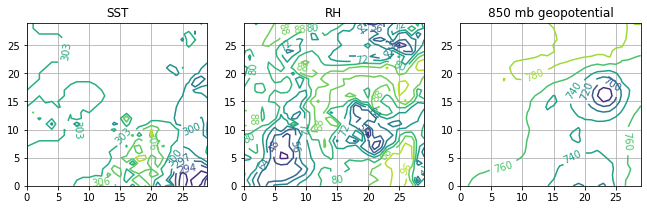

In [3]:
#
# visualize a few variables for checking the input data
#
print("Raw input data shape (nsample,nclass,ny,nx,nchannel) is: ",len(array_raw),len(array_raw[0]),
      len(array_raw[0][0]),len(array_raw[0][0][0]),len(array_raw[0][0][0][0]))

check_visualization = "yes"
if check_visualization== "yes":
    print("Plotting one example from raw data input")
    temp = np.array(array_raw[7][0])
    plt.figure(figsize=(11, 3)) 
    plt.subplot(1,3,1)
    CS = plt.contour(temp[:,:,4])
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('SST')
    plt.grid()

    plt.subplot(1,3,2)
    CS = plt.contour(temp[:,:,1])
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('RH')
    plt.grid()

    plt.subplot(1,3,3)
    CS = plt.contour(temp[:,:,9])
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('850 mb geopotential')
    plt.grid()

    plt.show()

In [4]:
#
# randomize data and generate training data (X,y)
#
import random
np.random.shuffle(array_raw)
X = []
y = []
for features,label in array_raw: 
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 12)
print(X.shape)
print(y)

(704, 30, 30, 12)
[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 

In [7]:
#
# save training data to an output for subsequent use
#
import pickle
pickle_out = open("tcg_X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("tcg_y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()